In [1]:
import os
import glob
import numpy as np
import xarray as xr
import pandas as pd

import matplotlib.pyplot as plt
import matplotlib.patches as mpatches
import matplotlib.gridspec as gridspec
%matplotlib inline
import matplotlib
from mpl_toolkits.axes_grid1 import make_axes_locatable
from mpl_toolkits.axes_grid1.inset_locator import inset_axes
matplotlib.rcParams.update({'font.size':15})

import cartopy.crs as ccrs
import cartopy

import sys
p = os.path.abspath('/global/homes/q/qnicolas/')
if p not in sys.path:
    sys.path.append(p)

import tools.generalTools as gt
import tools.e5tools as e5
import tropicalOrographicRegions.mountainUtils as mu

from scipy.stats import linregress
from scipy.ndimage import gaussian_filter
from scipy.integrate import cumtrapz

from cartopy.mpl.ticker import LongitudeFormatter, LatitudeFormatter
from matplotlib.legend_handler import HandlerLine2D
import matplotlib.lines
import warnings

%load_ext autoreload
%autoreload 2

/global/common/software/m3310/conda/xrdask.2023.11.qn/lib/python3.9/site-packages/pyproj/__init__.py:89: UserWarning: pyproj unable to set database path.
  _pyproj_global_context_initialize()


In [ ]:
10.5281/zenodo.11479598

# Functions, data

## various functions

In [6]:
# Linear theory
def m_exponent_damped(k,N,U,xi,hydrostatic=False):
    lz2 = N**2/U**2/(1-1j*xi/(k*U))
    sgnk = np.sign(k)
    if hydrostatic:
        k=1e-10
    m1 = (np.real(lz2) < k**2 ) * 1j*np.sqrt(k**2-lz2 + 0.j) 
    m2 = (np.real(lz2) >= k**2) * sgnk *np.sqrt(lz2-k**2 + 0.j)
    return 1j * (m1 + m2)

def linear_zeta_damped(h,N,U,x,z,xi=1./86400.,hydrostatic=False):
    k=orog.k_vector(len(x),x[1]-x[0]); k[0] = 1e-10 # dummy nonzero value
    h_hat = np.fft.fft(hx); h_hat[0] = 0.
    zetahat = h_hat[:,None]*np.exp( m_exponent_damped(k[:,None],N,U,xi,hydrostatic=hydrostatic)  *  z[None,:])
    Tz = 300. + (300.*N**2/9.81 - 9.81/1004.)*z
    lnpz = - cumtrapz(9.81/(287.*Tz),z,initial=0.)
    zeta=xr.DataArray(np.real(np.fft.ifft(zetahat,axis=0)),coords={'x':x/1e3,'z':z,'p':('z',1000.*np.exp(lnpz))},dims={'x':x/1e3,'z':z})
    return zeta


def linear_precip_theory_damped(xx,hx,N,U,xi=1./86400.,tauT=7.5 * 3600,tauq=27.5 * 3600,switch=1,zbot=1000,ztop=4000,hydrostatic=False):
    pT_ov_g = 8e3 #mass of troposphere in kg/m2
    Lv = 2.5e6; cp=1004.; g = 9.81
    
    z=np.arange(zbot,ztop+1,10.)
    k=orog.k_vector(len(xx),xx[1]-xx[0]); k[0] = 1e-10 # dummy nonzero value
    h_hat = np.fft.fft(hx); h_hat[0] = 0.

    Lq=orog.compute_Lq(5,U,tauq)
    
    ds0dz = 300./g * N**2 * cp
    dq0dz = Lv * np.gradient(0.015 * np.exp(-z/2500),z)#.mean()
    
    chi = pT_ov_g * (ds0dz/tauT - dq0dz/tauq)/ Lv * 86400
    
    #Pprimehat = 1j*k/(1j*k + switch*1/Lq) * chi * h_hat * np.exp( m_exponent_damped(k[:,None],N,U,xi)  *  z[None,:]).mean(axis=1) 
    Pprimehat = 1j*k/(1j*k + switch*1/Lq)* h_hat * (chi * np.exp( m_exponent_damped(k[:,None],N,U,xi,hydrostatic=hydrostatic)  *  z[None,:])).mean(axis=1) 
    
    P = np.real(np.fft.ifft(Pprimehat))
    return P

In [7]:
# Bootstrapping
def generate_sample(raints,blocksize = 1,nbootstrap = 10000):
    Nt = len(raints)
    nsamples_per_bootstrap = Nt//blocksize
    nsamples = nbootstrap*nsamples_per_bootstrap
    
    idxs = np.random.choice(Nt-blocksize,nsamples,replace=True)
    idx_blocks = np.broadcast_to(idxs,(blocksize,nsamples)).T + np.arange(blocksize)
    bootstrap_samples = raints[idx_blocks].reshape(nbootstrap,nsamples_per_bootstrap*blocksize)
    return bootstrap_samples

In [8]:
# Simulations
def upstream_mean(ds,reverse=False):
    if reverse:
        return ds.sel(distance_from_mtn=slice(-4000,-2500)).mean('distance_from_mtn')
    else:
        return ds.sel(distance_from_mtn=slice(-2500,-4000)).mean('distance_from_mtn')
    
def prime(ds,reverse=False):
    return ds - upstream_mean(ds,reverse)

def averageB(ds,psfc,ptop=850):
    ds = ds.bfill(dim='pressure')
    p1 = 990;p2=ptop
    part1 = -ds.sel(pressure=slice(p1,p2)).integrate('pressure')
    part2 = ds.sel(pressure=p1)*(psfc-990)
    return ((part1+part2)/(psfc-ptop))
def averageL(ds,p1 = 850,p2 = 500):
    return (-ds.sel(pressure=slice(p1,p2)).integrate('pressure')/(p1-p2))


In [9]:
# Observations
def sel_box_months(var,box,months,lon='longitude',lat='latitude',lat_increase=False):
    window = sel_box(var,box,lon,lat,lat_increase)
    window=sel_months(window,months)
    return window

def add_wind(ax,u,v,color='k',width=0.001,scale=600,key=True,ref=10,unit='m/s',pos=(0.87,1.03),nm=5,fontproperties=None):
    ax.coastlines()
    X = u.latitude.expand_dims({"longitude":u.longitude}).transpose()
    Y = v.longitude.expand_dims({"latitude":u.latitude})
    n=nm
    m=nm
    q=ax.quiver(np.array(Y)[::n,::m],np.array(X)[::n,::m], np.array(u)[::n,::m], np.array(v)[::n,::m], transform=ccrs.PlateCarree(),color=color,width=width,scale=scale)
    if key:
        ax.quiverkey(q, *pos, ref, label='%i %s'%(ref,unit), labelpos='E', coordinates='axes',color='k',fontproperties=fontproperties)
    return q

def add_latlon(ax,box,ftz=None):
    ax.set_anchor('W')
    dl=5
    lons=range(dl*(1+(int(box[0])-1)//dl),dl*(int(box[1])//dl)+1,dl)
    lats=range(dl*(1+(int(box[2])-1)//dl),dl*(int(box[3])//dl)+1,dl)
    
    ax.set_xticks(lons, crs=ccrs.PlateCarree())
    ax.set_yticks(lats, crs=ccrs.PlateCarree())
    lon_formatter = LongitudeFormatter(zero_direction_label=True)
    lat_formatter = LatitudeFormatter()
    ax.xaxis.set_major_formatter(lon_formatter)
    ax.yaxis.set_major_formatter(lat_formatter)
    if ftz:
        ax.tick_params(axis='both', which='major', labelsize=ftz)
    
    ax.set_xlabel("")
    ax.set_ylabel("")

def reorder(da):
    da.coords['longitude'] = da.coords['longitude'] % 360
    da = da.sortby(da.longitude)
    return da.reindex(latitude=list(reversed(da.latitude)))
 
def smooth(ds):
    return xr.apply_ufunc(gaussian_filter,ds,kwargs={"sigma":2.})


## Simulations

In [7]:
from tools.wrfHrTools import Simulation,change_coords_pl

In [8]:
import orographicConvectionTheory.orographicConvectionTheory as orog 
xx,hx=orog.topographic_profile('cos',A=500.)

In [9]:
class SimulationPlots():
    def __init__(self,path):        
        self.path = path
        #RAINNC_DAILY = xr.open_zarr(self.path+'wrf.RAINNC.1h.ALL_CONCAT.zarr').RAINNC_MMDY.mean('south_north').coarsen(Time=24).mean()[cutoff:].compute()
        
        self.RAINNC_DAILY = xr.open_dataarray(self.path+'wrf.RAINNC.DAILY.nc').mean('south_north')
        self.RAINNC_STERR = 2 * self.RAINNC_DAILY.std('Time') / np.sqrt(len(self.RAINNC_DAILY.Time))
        self.RAINNC_MEAN = self.RAINNC_DAILY.mean('Time')
        
        self.TL_DAILY      = xr.open_dataarray(self.path + 'wrf.TL_600_900.DAILY.YAVG.nc')
        self.QL_DAILY      = xr.open_dataarray(self.path + 'wrf.QL_600_900.DAILY.YAVG.nc')
        self.THETAEB_DAILY = xr.open_dataarray(self.path + 'wrf.THETAEB_900.DAILY.YAVG.nc')
        
        self.TL_MEAN      = self.TL_DAILY     .mean('Time')
        self.QL_MEAN      = self.QL_DAILY     .mean('Time')
        self.THETAEB_MEAN = self.THETAEB_DAILY.mean('Time')
        
        self.T_PL_MEAN = xr.open_dataarray(self.path+'wrf.T_PL.TIMEAVG.YAVG.nc')
        self.Q_PL_MEAN = xr.open_dataarray(self.path+'wrf.Q_PL.TIMEAVG.YAVG.nc')
        self.W_PL_MEAN = xr.open_dataarray(self.path+'wrf.W_PL.TIMEAVG.YAVG.nc')
        self.U_PL_MEAN = xr.open_dataarray(self.path+'wrf.U_PL.TIMEAVG.YAVG.nc')
        self.THETAE_PL_MEAN = xr.open_dataarray(self.path+'wrf.THETAE_PL.TIMEAVG.YAVG.nc')
        
        self.PSFC_MEAN = xr.open_dataarray(self.path+'wrf.PSFC.TIMEAVG.YAVG.nc')

#W10S300   = SimulationCustom2('/pscratch/sd/q/qnicolas/wrfdata/saved/channel.wrf.100x2.mountain.60lev.500m.3km/'          ,1635,3,'1970010100-1970072000',inp=True)
#W12S300   = SimulationCustom2('/pscratch/sd/q/qnicolas/wrfdata/saved/channel.wrf.100x2.mountain.60lev.500m.12mps.3km/'          ,1635,3,'1970010100-1971010400',inp=True)   
W10S300   = SimulationPlots('data/wrfData/W10S300/')
W12S300   = SimulationPlots('data/wrfData/W12S300/')   

In [10]:
W10S300.lns='-'
W12S300.lns='--'

W10S300.label=r'$U = 10$ m$\,$s$^{-1}$'
W12S300.label=r'$U = 12$ m$\,$s$^{-1}$'

In [28]:
#W10S300.path2 = '/pscratch/sd/q/qnicolas/wrfdata/saved/channel.wrf.100x2.mountain.60lev.500m.3km/'      
#W12S300.path2 = '/pscratch/sd/q/qnicolas/wrfdata/saved/channel.wrf.100x2.mountain.60lev.500m.12mps.3km/'
#
#W10S300.desc = "U = 10 m/s"
#W12S300.desc = "U = 12 m/s"
#
#W10S300.days = "201-1301"
#W12S300.days = "201-1296"
#
#for Sim in W10S300,W12S300:
#    Sim.U_PL_MEAN = xr.open_dataarray(Sim.path2+'wrf.U_PL.ALLMEAN.nc')
#    Sim.THETAE_PL_MEAN = xr.open_dataarray(Sim.path2 + "wrf.THETAE.ALLMEAN.nc")
#    
#    Sim.U_PL_MEAN     .attrs['Description'] = """Time-mean, meridional-mean zonal wind over days %s. WRF simulation with dx=3km, 500 m mountain, SST = 300 K, background wind """%Sim.days+Sim.desc
#    Sim.THETAE_PL_MEAN.attrs['Description'] = """Time-mean, meridional-mean equivalent potential temperature over days %s. WRF simulation with dx=3km, 500 m mountain, SST = 300 K, background wind """%Sim.days+Sim.desc
#    Sim.U_PL_MEAN     .attrs['Units'] = 'm s^-1'
#    Sim.THETAE_PL_MEAN.attrs['Units'] = 'K'
#    Sim.U_PL_MEAN     .to_netcdf(Sim.path+'wrf.U_PL.TIMEAVG.YAVG.nc')
#    Sim.THETAE_PL_MEAN.to_netcdf(Sim.path+'wrf.THETAE_PL.TIMEAVG.YAVG.nc')
#    

## Observations

In [2]:
class PrecipDataset :
    def __init__(self, data, name):
        self.name=name
        self.precip=data
        self.resolution = ("%.3f"%float(data.longitude[1]-data.longitude[0])).rstrip('0')+"°"
        self.time_range = (pd.to_datetime(data.time.min().values).strftime("%Y-%m"),pd.to_datetime(data.time.max().values).strftime("%Y-%m"))

class MountainRangeSimple():
    def __init__(self,name, box,months, tilted_rect,angle,P0,Lname=''):
        self.name = name
        self.Lname = Lname
        self.box = box
        self.tilted_rect = tilted_rect
        self.angle = angle
        self.P0=P0
        self.months = months
        self._monthstr = '-'.join(["{:02}".format(m) for m in self.months])
        self.vars={}
        self.vars['U100_DAILY'] = xr.open_dataarray("data/regionsData/e5.oper.an.sfc.228_246_100u.ll025sc.2001-2020.{}.{}.nc".format(self._monthstr,self.name))
        self.vars['V100_DAILY'] = xr.open_dataarray("data/regionsData/e5.oper.an.sfc.228_247_100v.ll025sc.2001-2020.{}.{}.nc".format(self._monthstr,self.name))
        self.vars['IMERG_DAILY'] = xr.open_dataarray("data/regionsData/gpm_imerg_v06.2001-2020.{}.{}.nc".format(self._monthstr,self.name))

        imerg_lsm = lsm.interp_like(self.vars['IMERG_DAILY'])>0.1
        mask_above_imerg = imerg_lsm * mu.tilted_rect(self.vars['IMERG_DAILY'],*self.tilted_rect,reverse=False)
        mask_upstream_imerg = mu.tilted_rect_distance(self.vars['IMERG_DAILY'],*self.tilted_rect[:-1],-2,-4)
        mask_wind_era5 = mu.tilted_rect(self.vars['U100_DAILY'],*self.tilted_rect,reverse=True)
        
        self.vars['IMERG_DAILY_ABOVE'] = gt.spatial_mean(self.vars['IMERG_DAILY'],mask=mask_above_imerg,box=None)
        self.vars['IMERG_DAILY_UPSTREAM'] = gt.spatial_mean(self.vars['IMERG_DAILY'],mask=mask_upstream_imerg,box=None)
        self.vars['U100_DAILY_BOXWIND'] = gt.spatial_mean(self.vars['U100_DAILY'],mask=mask_wind_era5,box=None)
        self.vars['V100_DAILY_BOXWIND'] = gt.spatial_mean(self.vars['V100_DAILY'],mask=mask_wind_era5,box=None)
        
        
box = [60,135,-5,30]

In [3]:
topo_hires = xr.open_dataset("data/globalData/ETOPO1_Ice_g_gmt4.grd").z.rename({'x':'longitude','y':'latitude'})
topo_hires = topo_hires.reindex(latitude=list(reversed(topo_hires.latitude)))
topo_hires.coords['longitude'] = topo_hires.coords['longitude'] % 360
topo_hires = topo_hires.sortby(topo_hires.longitude)
orogm = xr.open_dataset("data/globalData/e5.oper.invariant.128_129_z.ll025sc.1979010100_1979010100.nc").Z.isel(time=0)/9.81
lsm = xr.open_dataset("data/globalData/e5.oper.invariant.128_172_lsm.ll025sc.1979010100_1979010100.nc").LSM.isel(time=0)

In [4]:

Ghats = MountainRangeSimple      ('ghats'      ,[67, 91, 5.5, 27],[6,7,8]   ,[75, 9, 71.5, 20,2]              ,70  ,3 , Lname='Western Ghats')
Myanmar = MountainRangeSimple    ('myanmar'    ,[82,102,5.5,27]  ,[6,7,8]   ,[94.2, 16.5,  91.4  , 21.5 , 1.5],50  ,6 , Lname='Myanmar')#[94.5, 17,  91.5  , 21.5 , 1.5], [94, 15,  91  , 21.5 , 2]
Vietnam = MountainRangeSimple    ('vietnam'    ,[100,118,8,25]   ,[10,11,12],[108  ,  18  , 111  , 13   ,2]   ,240 ,4 , Lname='Vietnam')#[108, 18, 110, 15, 2]
Philippines = MountainRangeSimple('philippines',[118,135,5,22]   ,[11,12]   ,[122.5, 19, 127, 9, 2]           ,225 ,10, Lname='Philippines')
Malaysia = MountainRangeSimple   ('malaysia'   ,[95,115,-2,15]   ,[11,12]   ,[102.5,   8  , 105.5,  3   ,2]   ,225 ,4 , Lname='Malaysia')
MRs = (Ghats,Myanmar,Vietnam,Philippines,Malaysia)

/global/common/software/m3310/conda/xrdask.2023.11.qn/lib/python3.9/site-packages/xarray/core/computation.py:761: RuntimeWarning: invalid value encountered in sqrt
  result_data = func(*input_data)
/global/common/software/m3310/conda/xrdask.2023.11.qn/lib/python3.9/site-packages/xarray/core/computation.py:761: RuntimeWarning: invalid value encountered in sqrt
  result_data = func(*input_data)
/global/common/software/m3310/conda/xrdask.2023.11.qn/lib/python3.9/site-packages/xarray/core/computation.py:761: RuntimeWarning: invalid value encountered in sqrt
  result_data = func(*input_data)
/global/common/software/m3310/conda/xrdask.2023.11.qn/lib/python3.9/site-packages/xarray/core/computation.py:761: RuntimeWarning: invalid value encountered in sqrt
  result_data = func(*input_data)
/global/common/software/m3310/conda/xrdask.2023.11.qn/lib/python3.9/site-packages/xarray/core/computation.py:761: RuntimeWarning: invalid value encountered in sqrt
  result_data = func(*input_data)


In [10]:
#aphrodite_path = "/global/cfs/projectdirs/m3310/qnicolas/APHRODITE/"
aphrodite_1 = xr.open_dataset("data/globalData/APHRO_MA_025deg_V1101.1951-2007.monthly.nc")
aphrodite_2 = xr.open_dataset("data/globalData/APHRO_MA_025deg_V1101_EXR1.2007-2015.monthly.nc")
aphrodite_monthly = reorder(xr.concat((aphrodite_1.precip.sel(time=(aphrodite_1['time.year']<2007)),\
                                       aphrodite_2.precip.rename({'lat':'latitude','lon':'longitude'})),\
                                      dim='time'))

In [11]:
#e5_pr_monthly = 1e3*e5_monthly_timeseries('128_228_tp',range(1979,2021))
e5_pr_monthly_1979_2020 = xr.open_zarr("data/globalData/e5.monthly.precip.1979-2020.zarr").TP*1e3
#e5_pr_monthly_1950_1978 = 1e3*e5.e5_monthly_timeseries('128_228_tp',range(1950,1979))
e5_pr_monthly_1950_1978 = xr.open_zarr("data/globalData/e5.monthly.precip.1950-1978.zarr").tp*1e3
e5_pr_monthly = xr.concat((e5_pr_monthly_1950_1978,e5_pr_monthly_1979_2020),dim='time')

In [12]:
APHRODITE = PrecipDataset(aphrodite_monthly,'APHRODITE')
ERA5      = PrecipDataset(e5_pr_monthly,'ERA5 precip')
datasets = (APHRODITE, ERA5 )

In [13]:
%%time
for dataset in datasets:
    dataset.precip_seasonal_yearly = {}
    for monthgroup in (6,7,8),(10,11,12),(11,12):
        dataset.precip_seasonal_yearly[monthgroup] = gt.sel_box_months(dataset.precip,box = box, months=monthgroup).groupby('time.year').mean().load()

CPU times: user 14.4 s, sys: 50.9 s, total: 1min 5s
Wall time: 4.2 s


In [14]:
for dataset in datasets:
    dataset.lsm = lsm.interp_like(dataset.precip_seasonal_yearly[(11,12)])>0.1

In [15]:
%%time
#e5_100u_1979_2020 = e5.e5_monthly_timeseries('228_246_100u',range(1979,2021))
#e5_100v_1979_2020 = e5.e5_monthly_timeseries('228_247_100v',range(1979,2021))
#e5_100u_1950_1978 = e5.e5_monthly_timeseries('228_246_100u',range(1950,1979))
#e5_100v_1950_1978 = e5.e5_monthly_timeseries('228_247_100v',range(1950,1979))
e5_100u_1979_2020 = xr.open_zarr("data/globalData/e5.monthly.228_246_100u.1979-2020.zarr").VAR_100U
e5_100v_1979_2020 = xr.open_zarr("data/globalData/e5.monthly.228_247_100v.1979-2020.zarr").VAR_100V
e5_100u_1950_1978 = xr.open_zarr("data/globalData/e5.monthly.228_246_100u.1950-1978.zarr").u100
e5_100v_1950_1978 = xr.open_zarr("data/globalData/e5.monthly.228_247_100v.1950-1978.zarr").v100


e5_100u_monthly = xr.concat((e5_100u_1950_1978,e5_100u_1979_2020),dim='time')
e5_100v_monthly = xr.concat((e5_100v_1950_1978,e5_100v_1979_2020),dim='time')

e5_100u_seasonal_yearly = {}
e5_100v_seasonal_yearly = {}
for monthgroup in (6,7,8),(10,11,12),(11,12):
    e5_100u_seasonal_yearly[monthgroup] = gt.sel_box_months(e5_100u_monthly,box = box, months=monthgroup).groupby('time.year').mean().load()
    e5_100v_seasonal_yearly[monthgroup] = gt.sel_box_months(e5_100v_monthly,box = box, months=monthgroup).groupby('time.year').mean().load()


CPU times: user 27.1 s, sys: 1min 7s, total: 1min 34s
Wall time: 7.69 s


In [16]:
for dataset in datasets:
    dataset.region_masks = {}
    for MR in MRs:
        dataset.region_masks[MR.name] = gt.sel_box(dataset.lsm*mu.tilted_rect(dataset.lsm,*MR.tilted_rect),box)

## CMIP

In [7]:
import fsspec
import cftime

df = pd.read_csv('https://storage.googleapis.com/cmip6/cmip6-zarr-consolidated-stores.csv')
df_uas_hist = df.query("activity_id=='CMIP' & table_id == 'Amon' & variable_id == 'uas' & experiment_id == 'historical'")
df_uas_ssp5 = df.query("activity_id=='ScenarioMIP' & table_id == 'Amon' & variable_id == 'uas' & experiment_id == 'ssp585'")


def subselect(first_table,second_table):
    source_ids = second_table['source_id'].unique()
    mask = first_table['source_id'].isin(source_ids)
    return first_table[mask]

df_uas_hist_itsct = subselect(df_uas_hist,df_uas_ssp5)
df_uas_ssp5_itsct = subselect(df_uas_ssp5,df_uas_hist)

source_ids = df_uas_hist_itsct['source_id'].unique()
#source_ids = [s for s in source_ids if s!='MPI-ESM1-2-HR'] # Exclude because the name of the modeling center switches from MPI to DKRZ between historical and ssp585

In [8]:
from scipy.interpolate import griddata

def interpolate_nans(data):
    # Get the coordinates of the non-null values
    latindex, lonindex = np.where(~np.isnan(data.values))
    points = np.stack((data.longitude.values[lonindex],data.latitude.values[latindex]), axis=-1)
    # Get the values of the non-null points
    values = data.values[~np.isnan(data.values)]
    # Create a grid of points to interpolate onto
    grid_x, grid_y = np.meshgrid(data.longitude, data.latitude)
    # Perform the interpolation
    #return points, values
    interpolated = griddata(points, values, (grid_x, grid_y), method='linear')
    # Return a new DataArray with the interpolated values
    return xr.DataArray(interpolated, dims=data.dims, coords=data.coords, name = data.name)

def destagger(data,typ='u'):
    if typ=='u':
        latindex, _ = np.where(~np.isnan(data.values))
        lonindex = np.where((~np.isnan(data)).sum('latitude') == 0)[0]
    elif typ=='v':
        _, lonindex = np.where(~np.isnan(data.values))
        latindex = np.where((~np.isnan(data)).sum('longitude') == 0)[0]
    return interpolate_nans(data)[sorted(list(set(latindex))),sorted(list(set(lonindex)))]
    

In [9]:
# def standardize(ds):
#     #try:
#     #    ds['time'] = ds.indexes['time'].to_datetimeindex()
#     #except AttributeError:
#     #    pass
#     if 'lat' in ds.coords:
#         return ds.rename(lat='latitude',lon='longitude')
#     else:
#         assert 'latitude' in ds.coords
#         return ds

# hist_uas = {}
# hist_vas = {}
# ssp5_uas = {}
# ssp5_vas = {}

# for source_id in source_ids:
#     institution_id = df_uas_hist_itsct[df_uas_hist_itsct['source_id']==source_id].iloc[0]['institution_id']
#     hist_uas[source_id] = standardize(xr.open_zarr('/pscratch/sd/q/qnicolas/cmipData/CMIP.historical.%s.%s.Amon.uas.1980-1999.zarr'%(institution_id,source_id)).uas)
#     hist_vas[source_id] = standardize(xr.open_zarr('/pscratch/sd/q/qnicolas/cmipData/CMIP.historical.%s.%s.Amon.vas.1980-1999.zarr'%(institution_id,source_id)).vas)
#     try:
#         ssp5_uas[source_id] = standardize(xr.open_zarr('/pscratch/sd/q/qnicolas/cmipData/ScenarioMIP.ssp585.%s.%s.Amon.uas.2080-2099.zarr'%(institution_id,source_id)).uas)
#         ssp5_vas[source_id] = standardize(xr.open_zarr('/pscratch/sd/q/qnicolas/cmipData/ScenarioMIP.ssp585.%s.%s.Amon.vas.2080-2099.zarr'%(institution_id,source_id)).vas)
#     except FileNotFoundError: # One model has the name of the center changed between Historical and ssp585
#         institution_id = 'DKRZ'
#         ssp5_uas[source_id] = standardize(xr.open_zarr('/pscratch/sd/q/qnicolas/cmipData/ScenarioMIP.ssp585.%s.%s.Amon.uas.2080-2099.zarr'%(institution_id,source_id)).uas)
#         ssp5_vas[source_id] = standardize(xr.open_zarr('/pscratch/sd/q/qnicolas/cmipData/ScenarioMIP.ssp585.%s.%s.Amon.vas.2080-2099.zarr'%(institution_id,source_id)).vas)

# def get_us(MR,hist_u,hist_v,ssp5_u,ssp5_v):
#     hist_uperps_sub_boxmean = {}
#     ssp5_uperps_sub_boxmean = {}
#     hist_uvs_sub = {}
#     ssp5_uvs_sub = {}
#     for u,v,uvs,uperps in [(hist_u,hist_v,hist_uvs_sub,hist_uperps_sub_boxmean),(ssp5_u,ssp5_v,ssp5_uvs_sub,ssp5_uperps_sub_boxmean)]:
#         for k in u.keys():
#             lon='longitude';lat='latitude'
#             u_sub = gt.sel_box_months(u[k] , MR.box, MR.months,lon=lon,lat=lat,lat_increase=True ).groupby('time.month').mean().mean(('month','ensmember'))
#             v_sub = gt.sel_box_months(v[k] , MR.box, MR.months,lon=lon,lat=lat,lat_increase=True ).groupby('time.month').mean().mean(('month','ensmember'))
            
#             uvs[k] = xr.merge((u_sub,v_sub))    .load()
#             if k in ['UKESM1-0-LL','HadGEM3-GC31-LL','KACE-1-0-G','ACCESS-CM2','ACCESS-ESM1-5','HadGEM3-GC31-MM']: # staggered models
#                 u_sub = destagger(uvs[k].uas,typ='u')
#                 v_sub = destagger(uvs[k].vas,typ='v')
#                 uvs[k] = xr.merge((u_sub,v_sub)).load()
            
#             uperp = gt.crossslopeflow(u_sub,v_sub,MR.angle)
#             uperp_sub_boxmean = gt.spatial_mean(uperp,mask = mu.tilted_rect(uperp,*MR.tilted_rect,True,lon=lon,lat=lat),lon=lon,lat=lat)
#             uperps[k] = uperp_sub_boxmean.load()
#     valid_models_hist = [k for k,v in hist_uperps_sub_boxmean.items() if not(np.isnan(v.data) or v.data< 0)]
#     valid_models_ssp5 = [k for k,v in ssp5_uperps_sub_boxmean.items() if not(np.isnan(v.data) or v.data< 0)]
#     valid_models_all = [v for v in valid_models_hist if v in valid_models_ssp5]
#     print("Hist valid: %i, ssp5 valid: %i, intersection: %i"%(len(valid_models_hist),len(valid_models_ssp5),len(valid_models_all)))
#     MR.hist_uperps_boxmean = hist_uperps_sub_boxmean
#     MR.ssp5_uperps_boxmean = ssp5_uperps_sub_boxmean
#     MR.hist_uvs = hist_uvs_sub
#     MR.ssp5_uvs = ssp5_uvs_sub
#     MR.valid_models = valid_models_all

In [ ]:
# %%time
# for source_id in source_ids:
#     print(source_id)
#     institution_id = df_uas_hist_itsct[df_uas_hist_itsct['source_id']==source_id].iloc[0]['institution_id']
#     hist_uas[source_id].groupby('time.month').mean().mean('ensmember').to_netcdf('/global/cfs/projectdirs/m3310/qnicolas/windSensitivityData/cmipData/CMIP.historical.%s.%s.monthmean.ensmean.uas.1980-1999.nc'%(institution_id,source_id))
#     hist_vas[source_id].groupby('time.month').mean().mean('ensmember').to_netcdf('/global/cfs/projectdirs/m3310/qnicolas/windSensitivityData/cmipData/CMIP.historical.%s.%s.monthmean.ensmean.vas.1980-1999.nc'%(institution_id,source_id))
#     ssp5_uas[source_id].groupby('time.month').mean().mean('ensmember').to_netcdf('/global/cfs/projectdirs/m3310/qnicolas/windSensitivityData/cmipData/ScenarioMIP.ssp585.%s.%s.monthmean.ensmean.uas.2080-2099.nc'%(institution_id,source_id))
#     ssp5_vas[source_id].groupby('time.month').mean().mean('ensmember').to_netcdf('/global/cfs/projectdirs/m3310/qnicolas/windSensitivityData/cmipData/ScenarioMIP.ssp585.%s.%s.monthmean.ensmean.vas.2080-2099.nc'%(institution_id,source_id))


In [24]:
for source_id in source_ids:
    institution_id = df_uas_hist_itsct[df_uas_hist_itsct['source_id']==source_id].iloc[0]['institution_id']
    hist_uas[source_id] = xr.open_dataarray('data/cmipData/CMIP.historical.%s.%s.monthmean.ensmean.uas.1980-1999.nc'%(institution_id,source_id))
    hist_vas[source_id] = xr.open_dataarray('data/cmipData/CMIP.historical.%s.%s.monthmean.ensmean.vas.1980-1999.nc'%(institution_id,source_id))
    ssp5_uas[source_id] = xr.open_dataarray('data/cmipData/ScenarioMIP.ssp585.%s.%s.monthmean.ensmean.uas.2080-2099.nc'%(institution_id,source_id))
    ssp5_vas[source_id] = xr.open_dataarray('data/cmipData/ScenarioMIP.ssp585.%s.%s.monthmean.ensmean.vas.2080-2099.nc'%(institution_id,source_id))
def get_us(MR,hist_u,hist_v,ssp5_u,ssp5_v):
    hist_uperps_sub_boxmean = {}
    ssp5_uperps_sub_boxmean = {}
    hist_uvs_sub = {}
    ssp5_uvs_sub = {}
    for u,v,uvs,uperps in [(hist_u,hist_v,hist_uvs_sub,hist_uperps_sub_boxmean),(ssp5_u,ssp5_v,ssp5_uvs_sub,ssp5_uperps_sub_boxmean)]:
        for k in u.keys():
            lon='longitude';lat='latitude'
            u_sub = gt.sel_box_months(u[k] , MR.box, MR.months,lon=lon,lat=lat,lat_increase=True ).mean('month')
            v_sub = gt.sel_box_months(v[k] , MR.box, MR.months,lon=lon,lat=lat,lat_increase=True ).mean('month')
            
            uvs[k] = xr.merge((u_sub,v_sub))    .load()
            if k in ['UKESM1-0-LL','HadGEM3-GC31-LL','KACE-1-0-G','ACCESS-CM2','ACCESS-ESM1-5','HadGEM3-GC31-MM']: # staggered models
                
                u_sub = destagger(uvs[k].uas,typ='u')
                v_sub = destagger(uvs[k].vas,typ='v')
                uvs[k] = xr.merge((u_sub,v_sub)).load()
            
            uperp = gt.crossslopeflow(u_sub,v_sub,MR.angle)
            uperp_sub_boxmean = gt.spatial_mean(uperp,mask = mu.tilted_rect(uperp,*MR.tilted_rect,True,lon=lon,lat=lat),lon=lon,lat=lat)
            uperps[k] = uperp_sub_boxmean.load()
    valid_models_hist = [k for k,v in hist_uperps_sub_boxmean.items() if not(np.isnan(v.data) or v.data< 0)]
    valid_models_ssp5 = [k for k,v in ssp5_uperps_sub_boxmean.items() if not(np.isnan(v.data) or v.data< 0)]
    valid_models_all = [v for v in valid_models_hist if v in valid_models_ssp5]
    print("Hist valid: %i, ssp5 valid: %i, intersection: %i"%(len(valid_models_hist),len(valid_models_ssp5),len(valid_models_all)))
    MR.hist_uperps_boxmean = hist_uperps_sub_boxmean
    MR.ssp5_uperps_boxmean = ssp5_uperps_sub_boxmean
    MR.hist_uvs = hist_uvs_sub
    MR.ssp5_uvs = ssp5_uvs_sub
    MR.valid_models = valid_models_all

In [25]:
%%time
with warnings.catch_warnings():
    warnings.filterwarnings("ignore", category=RuntimeWarning)
    for MR in MRs:
        get_us(MR, hist_uas, hist_vas, ssp5_uas, ssp5_vas)

Hist valid: 37, ssp5 valid: 37, intersection: 37
Hist valid: 37, ssp5 valid: 37, intersection: 37
Hist valid: 37, ssp5 valid: 37, intersection: 37
Hist valid: 37, ssp5 valid: 37, intersection: 37
Hist valid: 37, ssp5 valid: 37, intersection: 37
CPU times: user 12.5 s, sys: 6.85 s, total: 19.4 s
Wall time: 11.9 s


In [26]:
invalid_model  = [m for m in source_ids if Ghats.hist_uperps_boxmean[m] < 0]
invalid_model

['CAS-ESM2-0']

In [ ]:
count = 0
for m in source_ids:
    print(m, "%.1f - %.1f"%(180 / (len(hist_uas[m].latitude)-1), 360 / (len(hist_uas[m].longitude)-1)))
    
    if max(180 / (len(hist_uas[m].latitude)-1), 360 / (len(hist_uas[m].longitude)-1)) > 1.5 :
        count +=1
          
          
          

GFDL-CM4 1.0 - 1.3
IPSL-CM6A-LR 1.3 - 2.5
GISS-E2-1-G 2.0 - 2.5
CNRM-CM6-1 1.4 - 1.4
BCC-CSM2-MR 1.1 - 1.1
CNRM-ESM2-1 1.4 - 1.4
MIROC6 1.4 - 1.4
MRI-ESM2-0 1.1 - 1.1
GISS-E2-1-H 2.0 - 2.5
UKESM1-0-LL 1.3 - 1.9
CanESM5 2.9 - 2.8
CanESM5-CanOE 2.9 - 2.8
INM-CM4-8 1.5 - 2.0
INM-CM5-0 1.5 - 2.0
HadGEM3-GC31-LL 1.3 - 1.9
NESM3 1.9 - 1.9
CAMS-CSM1-0 1.1 - 1.1
MPI-ESM1-2-LR 1.9 - 1.9
MPI-ESM1-2-HR 0.9 - 0.9
GFDL-ESM4 1.0 - 1.3
MCM-UA-1-0 2.3 - 3.8
MIROC-ES2L 2.9 - 2.8
KACE-1-0-G 1.3 - 1.9
FGOALS-f3-L 1.0 - 1.3
CNRM-CM6-1-HR 0.5 - 0.5
ACCESS-CM2 1.3 - 1.9
ACCESS-ESM1-5 1.2 - 1.9
HadGEM3-GC31-MM 0.6 - 0.8
IITM-ESM 1.9 - 1.9
EC-Earth3-Veg 0.4 - 0.7
EC-Earth3 0.4 - 0.7
EC-Earth3-Veg-LR 1.1 - 1.1
AWI-CM-1-1-MR 0.9 - 0.9
CMCC-CM2-SR5 0.9 - 1.3
CAS-ESM2-0 1.4 - 1.4
EC-Earth3-CC 0.7 - 0.7
CMCC-ESM2 0.9 - 1.3
KIOST-ESM 1.9 - 1.9


# Theory + Simulation

In [16]:
xx,hx = orog.topographic_profile('cos',A=500)
zz = np.arange(0.,21e3,100.)

zeta_10 = linear_zeta_damped(hx,0.01,10.,xx,zz,hydrostatic=True)
zeta_12 = linear_zeta_damped(hx,0.01,12.,xx,zz,hydrostatic=True)

Pp_10 = linear_precip_theory_damped(xx,hx,0.01,10,ztop=4000,hydrostatic=True)
Pp_12 = linear_precip_theory_damped(xx,hx,0.01,12,ztop=4000,hydrostatic=True)
Pd_10 = linear_precip_theory_damped(xx,hx,0.01,10,ztop=4000,hydrostatic=True,switch=1e-4)
Pd_12 = linear_precip_theory_damped(xx,hx,0.01,12,ztop=4000,hydrostatic=True,switch=1e-4)

In [17]:
blocksize=20
Deltax=30

for Sim in W10S300,W12S300:
    imax_wrf = Sim.RAINNC_MEAN.argmax().data; imaxm_wrf = imax_wrf - Deltax//3; imaxp_wrf = imax_wrf + Deltax//3

    ts = (Sim.RAINNC_DAILY.isel(distance_from_mtn = imax_wrf) - upstream_mean(Sim.RAINNC_MEAN)).load().data
    Sim.Pprime_bootstrap_sample_max = generate_sample(ts,blocksize,nbootstrap=50000).mean(axis=1)
    
    ts = (Sim.RAINNC_DAILY.isel(distance_from_mtn = slice(imaxm_wrf,imaxp_wrf-1)).mean('distance_from_mtn') - upstream_mean(Sim.RAINNC_MEAN)).load().data
    Sim.Pprime_bootstrap_sample_aroundmax = generate_sample(ts,blocksize,nbootstrap=50000).mean(axis=1)
    
CI95_max = (np.quantile(W12S300.Pprime_bootstrap_sample_max/W10S300.Pprime_bootstrap_sample_max,[0.025,0.975])-1)/2*100
CI95_aroundmax = (np.quantile(W12S300.Pprime_bootstrap_sample_aroundmax/W10S300.Pprime_bootstrap_sample_aroundmax,[0.025,0.975])-1)/2*100

In [18]:
sens_max = [(Pd_12.max()/Pd_10.max() - 1) * 100 / 2, 
            (Pp_12.max()/Pp_10.max() - 1) * 100 / 2, 
            (prime(W12S300.RAINNC_MEAN).max() / prime(W10S300.RAINNC_MEAN).max() - 1).data*100/2
           ]
uncertainty_max = np.vstack(([0,0],[0,0],np.abs(CI95_max- sens_max[2]) )).T

dx = int((xx[1] - xx[0])/1e3); Deltax = 30
imaxd_theory10 = Pd_10.argmax(); imaxdm_theory10 = imaxd_theory10 - Deltax//dx; imaxdp_theory10 = imaxd_theory10 + Deltax//dx
imaxd_theory12 = Pd_12.argmax(); imaxdm_theory12 = imaxd_theory12 - Deltax//dx; imaxdp_theory12 = imaxd_theory12 + Deltax//dx
imax_theory10 = Pp_10.argmax(); imaxm_theory10 = imax_theory10 - Deltax//dx; imaxp_theory10 = imax_theory10 + Deltax//dx
imax_theory12 = Pp_12.argmax(); imaxm_theory12 = imax_theory12 - Deltax//dx; imaxp_theory12 = imax_theory12 + Deltax//dx
imax_wrf10 = W10S300.RAINNC_MEAN.argmax().data; imaxm_wrf10 = imax_wrf10 - Deltax//3; imaxp_wrf10 = imax_wrf10 + Deltax//3
imax_wrf12 = W12S300.RAINNC_MEAN.argmax().data; imaxm_wrf12 = imax_wrf12 - Deltax//3; imaxp_wrf12 = imax_wrf12 + Deltax//3

sens_aroundmax = [(Pd_12[imaxdm_theory12:imaxdp_theory12].mean()/Pd_10[imaxdm_theory10:imaxdp_theory10].mean() - 1) * 100 / 2,
                  (Pp_12[imaxm_theory12:imaxp_theory12].mean()/Pp_10[imaxm_theory10:imaxp_theory10].mean() - 1) * 100 / 2, 
                  (prime(W12S300.RAINNC_MEAN)[imaxm_wrf12:imaxp_wrf12].mean() / prime(W10S300.RAINNC_MEAN)[imaxm_wrf10:imaxp_wrf10].mean() - 1).data*100/2
                  ]
uncertainty_aroundmax = np.vstack(([0,0],[0,0],np.abs(CI95_aroundmax- sens_aroundmax[2]) )).T

/tmp/ipykernel_412570/247096527.py:189: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  fig.tight_layout(w_pad=1.,h_pad=1.)


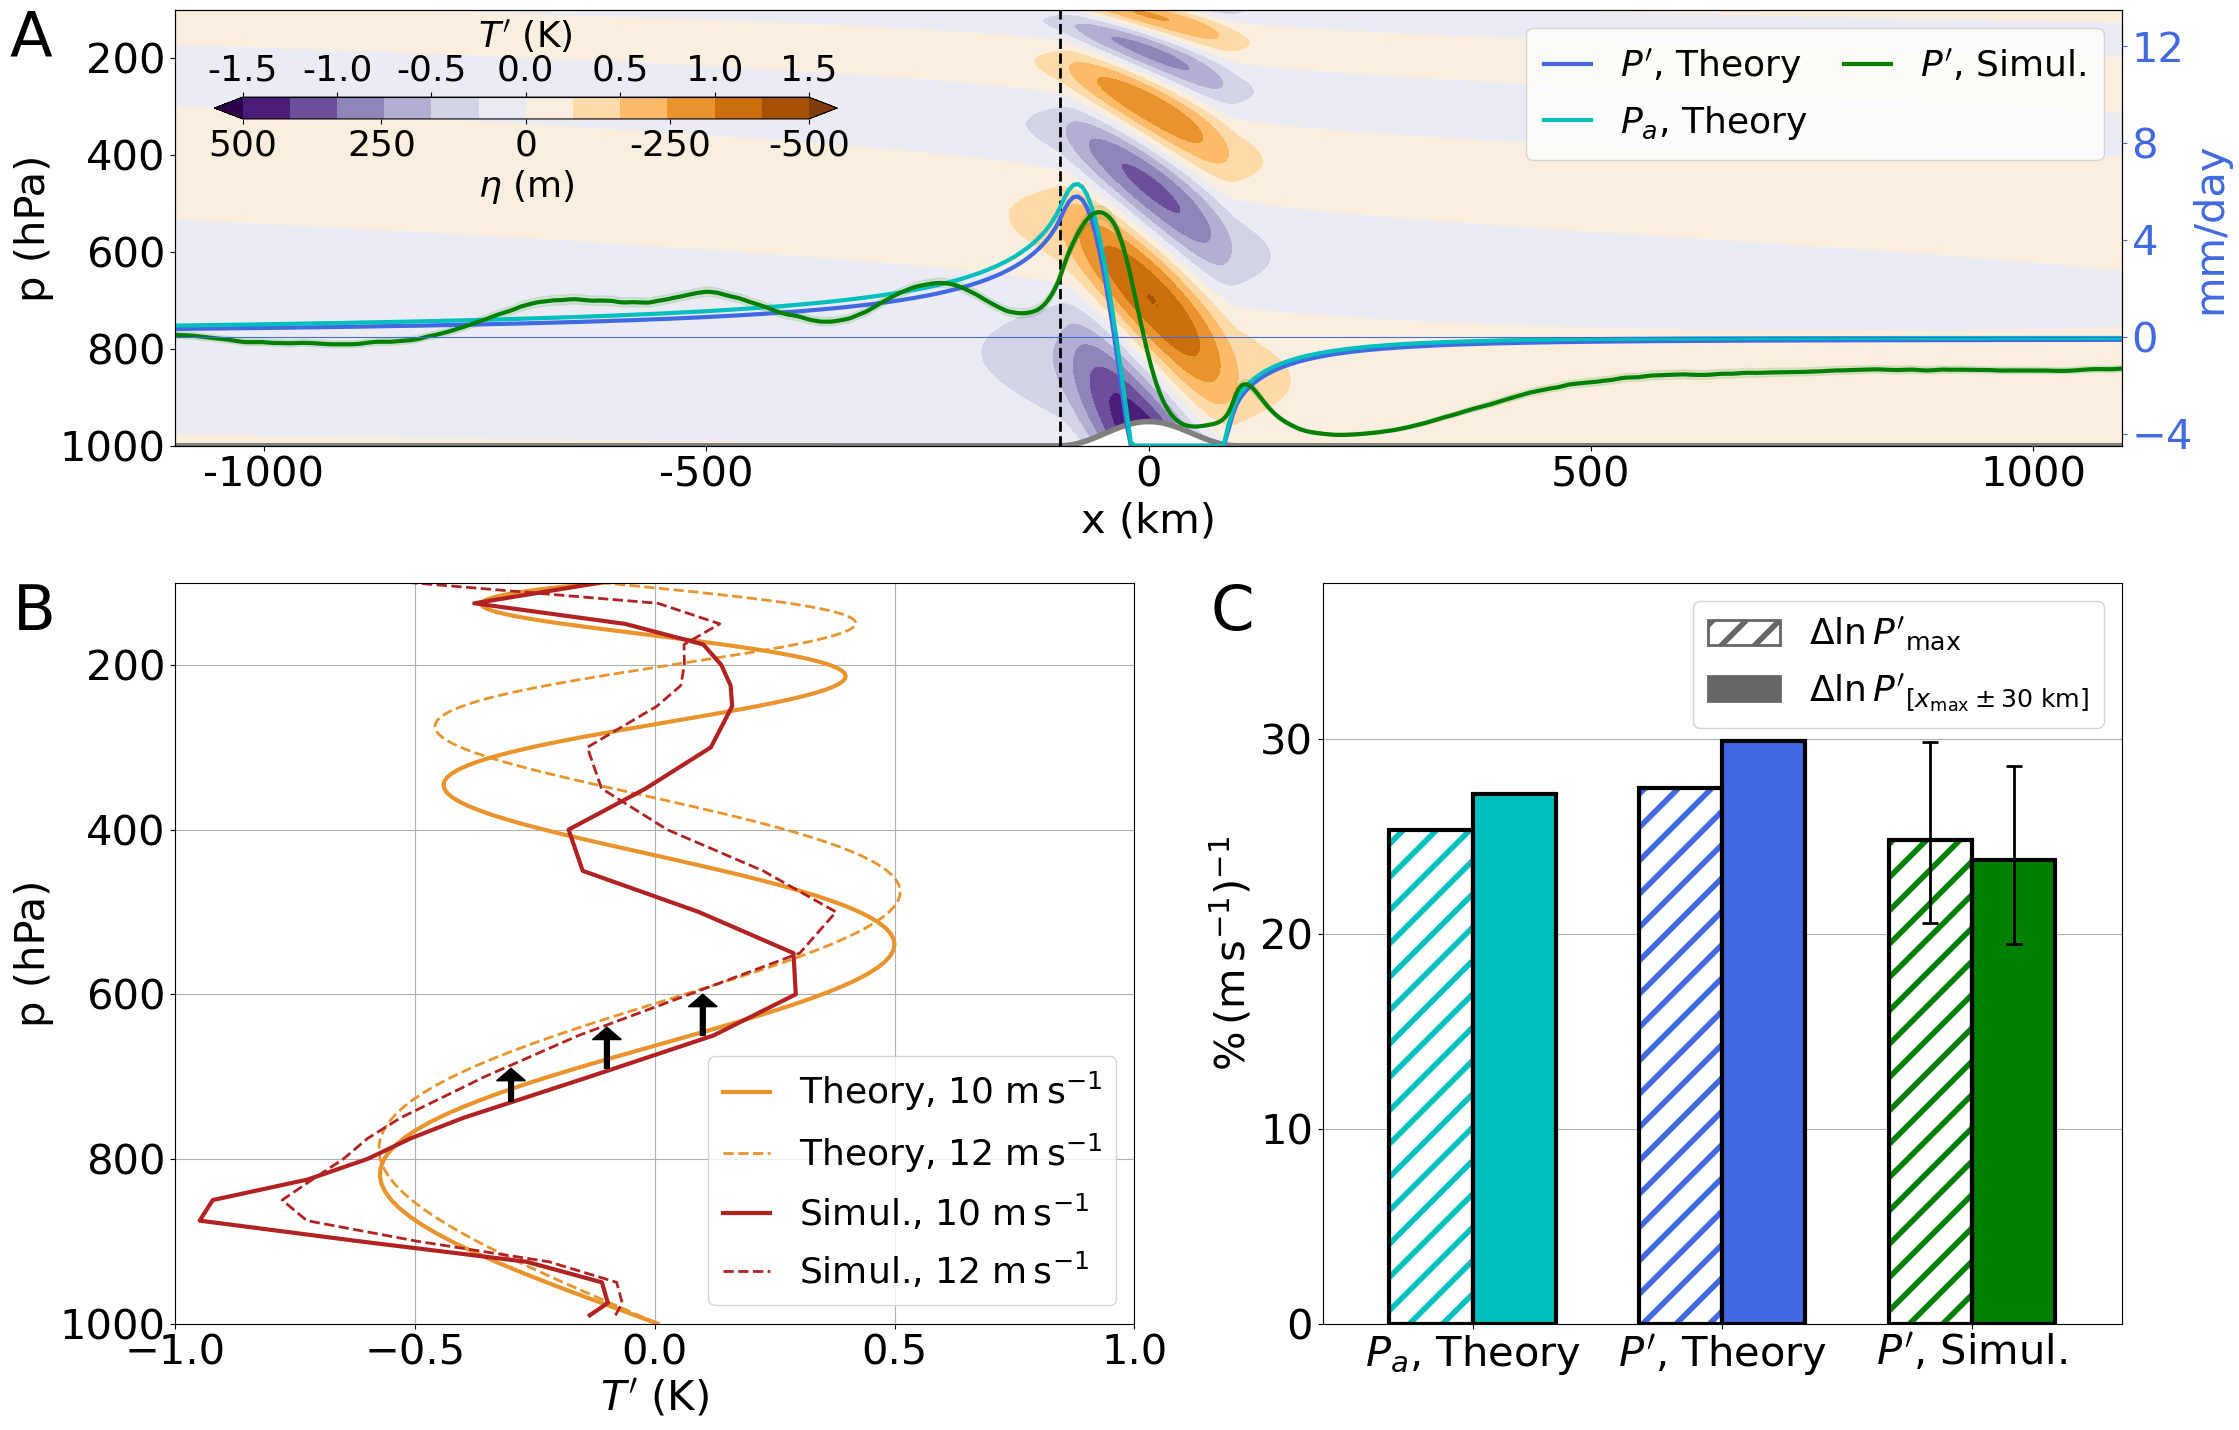

In [14]:
matplotlib.rcParams['hatch.linewidth'] = 4.0
matplotlib.rcParams.update({'font.size': 30})
legend_ftz = 26

fig = plt.figure(figsize=(23, 15))
gs = gridspec.GridSpec(nrows=2, ncols=2, height_ratios=[1., 1.7],width_ratios=[1.2, 1], figure=fig)
ax = fig.add_subplot(gs[0, :])
ax2 = fig.add_subplot(gs[1, 0])
ax3 = fig.add_subplot(gs[1, 1])  

###########################################
#### FIRST PLOT - eta in linear theory ####
###########################################
levs = np.arange(-1.5,1.6,0.25)
cbticks = np.arange(-500,501,250) # eta valeus
T_ticks = np.arange(-1.5,1.6,0.5)  # T' values
n=len(levs)

ds0dz = (300.*0.01**2/9.81)
im = (-ds0dz*zeta_10).swap_dims(z='p').plot.contourf(ax=ax, y='p',levels=levs,cmap = plt.cm.PuOr_r,extend='both',add_colorbar=False)

# plot rainfall
ax1 = ax.twinx()
xplot=zeta_10.x
precip_clr = 'royalblue'
ax1.plot(xplot,np.maximum(Pp_10,-4.5),color=precip_clr,linewidth=3,label=r"$P'$, Theory")
ax1.plot(xplot,np.maximum(Pd_10,-4.5),color='c',linewidth=3,label=r"$P_a$, Theory")


Sim = W10S300
prime(Sim.RAINNC_MEAN).plot(ax=ax1,color='g',label=r"$P'$, Simul.",linewidth=3,linestyle='-')
ax1.fill_between(Sim.RAINNC_MEAN.distance_from_mtn,prime(Sim.RAINNC_MEAN)-Sim.RAINNC_STERR,prime(Sim.RAINNC_MEAN)+Sim.RAINNC_STERR,alpha=0.1,color='g')

ax1.legend(loc=1,borderpad=0.5,fontsize=legend_ftz,ncol=2,columnspacing=1.,handlelength=1.3)


# ax1 cosmetics
ax1.set_ylabel("mm/day")
ax1.set_ylim(-4.5,13.5)
ax1.set_yticks(np.arange(-4,13,4))
ax1.axhline(0.,color=precip_clr,linestyle='-',linewidth=0.75)
#ax1.spines['bottom'].set_color(precip_clr)
#ax1.spines['top'].set_color(precip_clr)
ax1.yaxis.label.set_color(precip_clr)
ax1.tick_params(axis='y', colors=precip_clr)
ax1.yaxis.set_label_coords(1.035, 0.5)

# fill white space
ax.fill_between(xplot,1000*xplot**0,1000*xplot**0 - hx*0.1,color='w',zorder=2)
ax.plot(xplot,1000-hx/10,color='gray',linewidth=4)

#ax.axhline(900.,color='k',linestyle='--',linewidth=2)
#ax.axhline(600.,color='k',linestyle='--',linewidth=2)
dist = -100
ax.axvline(dist,color='k',linestyle='--',linewidth=2)

##############################################
#### Second PLOT - vertical T' structures ####
##############################################

(-ds0dz*zeta_10).swap_dims(z='p').sel(x=dist,method='nearest').plot(ax=ax2,y='p',color='#E9942D', label=r"Theory, 10 m$\,$s$^{-1}$",linewidth=3)
(-ds0dz*zeta_12).swap_dims(z='p').sel(x=dist,method='nearest').plot(ax=ax2,y='p',color='#E9942D', label=r"Theory, 12 m$\,$s$^{-1}$",linestyle='--',linewidth=2.)
#Tprime_Nz_10.sel(distance_from_mtn=-100,method='nearest').plot(ax=ax2,y='pressure',color='r')
#Tprime_Nz_12.sel(distance_from_mtn=-100,method='nearest').plot(ax=ax2,y='pressure',color='r',linestyle='--')
prime(W10S300.T_PL_MEAN).sel(distance_from_mtn=dist,method='nearest').plot(ax=ax2,y='pressure',color='firebrick', label=r"Simul., 10 m$\,$s$^{-1}$",linewidth=3)
prime(W12S300.T_PL_MEAN).sel(distance_from_mtn=dist,method='nearest').plot(ax=ax2,y='pressure',color='firebrick', label=r"Simul., 12 m$\,$s$^{-1}$",linestyle='--',linewidth=2.)

ax2.arrow(-0.3,730,0,-40,color='k',width=0.01,head_width=0.06,head_length=15.,zorder=20,length_includes_head=True)
ax2.arrow(-0.1,690,0,-50,color='k',width=0.01,head_width=0.06,head_length=15.,zorder=21,length_includes_head=True)
ax2.arrow( 0.1,650,0,-50,color='k',width=0.01,head_width=0.06,head_length=15.,zorder=22,length_includes_head=True)

ax2.grid()
ax2.set_title('')
ax2.set_xlim(-1.,1.)
ax2.set_xlabel(r"$T'$ (K)")
ax2.legend(fontsize=legend_ftz,handlelength=1.3)
#ax2.axhline(900.,color='k',linestyle='--',linewidth=2)
#ax2.axhline(600.,color='k',linestyle='--',linewidth=2)


######################################################
#### Third PLOT - bar plot of peak precip changes ####
######################################################
# set width of bars
nelems   = 2
nregions = 3
barWidth = 1/(nelems+1)
brs = np.arange(nregions)

##artificially create space in the legend
#ax3.scatter((0.,0.),(0.,0.),marker='.',color='none',label='     ')
#ax3.scatter((0.,0.),(0.,0.),marker='.',color='none',label='     ')

colors=['c',precip_clr,'green']
# draw hatch
ax3.bar(brs, sens_max,yerr = uncertainty_max, color ='w', width = barWidth, 
        edgecolor=colors,linewidth = 2., hatch="/", zorder=3,
        capsize=6,error_kw={'linewidth':2.,'markeredgewidth':2.}
       )  
# draw edges
ax3.bar(brs, sens_max, color ='none', width = barWidth, edgecolor='k',linewidth = 3., zorder=4)  
# draw full bars
ax3.bar(brs+barWidth, sens_aroundmax,yerr = uncertainty_aroundmax, color =colors, width = barWidth,
        edgecolor ='k',linewidth = 3., zorder=3.,
        capsize=6,error_kw={'linewidth':2.,'markeredgewidth':2.}
       )    

# For the legend
legend_color="#666666"
ax3.bar([-3], [2], color ='w', width = barWidth, 
        edgecolor=[legend_color],linewidth = 2., hatch="/", label = [r"$\Delta\ln P'_\max$"])
ax3.bar([-4], [2], color =legend_color, width = barWidth, 
        edgecolor=[legend_color],linewidth = 2., label = [r"$\Delta\ln P'_{[x_\max \pm 30\text{ km}]}$"])

ax3.grid(zorder=0,axis='y')

## Adding Xticks
ax3.set_ylabel(r"%$\,\left(\text{m}\,\text{s}^{-1}\right)^{-1}$")

ax3.legend(fontsize=legend_ftz)
ax3.set_xticks([1/6,7/6,7/6+1])
ax3.set_xticklabels([r"$P_a$, Theory",r"$P'$, Theory",r"$P'$, Simul."])

#ax3.legend(ncol=3,columnspacing=1,fontsize=legend_ftz,labelspacing=1.1,handletextpad=0.5,borderaxespad=0.2)
#ax3.text(0.07,0.935,'Theory:',transform = ax3.transAxes,fontsize=legend_ftz,zorder=20)
#ax3.text(0.07,0.835,'Simul.:',transform = ax3.transAxes,fontsize=legend_ftz,zorder=20)

D=0.6
ax3.set_xlim(1/6-D,7/6+1+D)
ax3.set_ylim(0,38)
ax3.set_yticks(range(0,31,10))

###############################
#### Some further settings ####
###############################

#for a in ax3,:
#    divider2 = make_axes_locatable(a)
#    cax2 = divider2.append_axes("right", size=2.05, pad=.6,axes_class=plt.Axes)
#    cax2.remove()


for a in ax,ax2:
    a.set_ylim(1000.,100)
    a.set_yticks(np.arange(200,1001,200))
    a.set_ylabel('p (hPa)')
    
ticks = np.arange(-1000,1100,500)
for a in ax,:
    a.set_xlim(-1100,1100)
    a.set_xticks(ticks)
    a.set_xticklabels('')
    a.set_xlabel('')
    a.set_xticklabels(ticks)
    a.set_xlabel('x (km)')
#ax2.axhline(-4.5,color='k',linestyle='--',linewidth=1.)

ax .text(-0.085,1.,'A',fontsize=45,transform=ax.transAxes,horizontalalignment='left',verticalalignment='top')
ax2.text(-0.17 ,1.,'B',fontsize=45,transform=ax2.transAxes,horizontalalignment='left',verticalalignment='top')
ax3.text(-0.14 ,1.,'C',fontsize=45,transform=ax3.transAxes,horizontalalignment='left',verticalalignment='top')

#fig.align_ylabels()


# Make the colorbar
axins = inset_axes(
    ax,
    width="100%",  # width: 5% of parent_bbox width
    height="100%",  # height: 50%
    #loc="upper left",
    bbox_to_anchor=(0.02,0.75, 0.32, 0.05),
    bbox_transform=ax.transAxes,
    borderpad=0.,
)
colorbar = plt.colorbar(im,cax=axins,label='',orientation='horizontal')
# Add left ticks
colorbar.ax.minorticks_off()
colorbar.ax.set_xticks(cbticks*ds0dz)
colorbar.ax.set_xticklabels(-cbticks,fontsize = legend_ftz)
colorbar.ax.set_xlabel(r"$\eta$ (m)",fontsize = legend_ftz)
#colorbar.ax.set_ylim(levs[-1],levs[0])
#colorbar.ax.text(-6,0.4,r"$\eta$ (m)",transform=colorbar.ax.transAxes,rotation='vertical')
# Add right ticks
secondary_axis = colorbar.ax.twiny()
secondary_axis.set_xticks(T_ticks)
secondary_axis.set_xticklabels(T_ticks,fontsize = legend_ftz)
secondary_axis.set_xlabel(r"$T'$ (K)",fontsize = legend_ftz)

fig.tight_layout(w_pad=1.,h_pad=1.)

#fig.tight_layout(w_pad=1.,h_pad=1.5)


fig.savefig('figs/wrf_theory.pdf',format='pdf',bbox_inches='tight')

# Simulations - convective closure

In [13]:
def smooth(ds):
    return xr.apply_ufunc(gaussian_filter,ds,kwargs={"sigma":2.})

class SymHandler(HandlerLine2D):
    def create_artists(self, legend, orig_handle,xdescent, ydescent, width, height, fontsize, trans):
        xx= 0.6*height
        return super(SymHandler, self).create_artists(legend, orig_handle,xdescent, xx, width, height, fontsize, trans)

In [14]:
for i,Sim in enumerate((W10S300, W12S300)):
    TL = Sim.TL_MEAN
    qL = Sim.QL_MEAN
    qL = qL * 2.5e6/1004.
    
    eB = Sim.THETAEB_MEAN
    
    conversion = 1004./2.5e6 * 8000 * 86400
    
    Sim.Pprime_tq  = conversion * (- prime(TL) / 7.5 + prime(qL)/27.5               )   / 3600
    Sim.Pprime_tqb = conversion * (- prime(TL) / 7.5 + prime(qL)/27.5 + prime(eB)/27.5) / 3600
    
    #Sim.Pprime_tq_daily  = conversion * (- (Sim.TL_DAILY - upstream_mean(Sim.TL_DAILY.mean('Time'))) / 7.5 + (Sim.QL_DAILY - upstream_mean(Sim.QL_DAILY.mean('Time')))* 2.5e6/1004./27.5               )   / 3600
    #Sim.Pprime_tqb_daily = conversion * (- (Sim.TL_DAILY - upstream_mean(Sim.TL_DAILY.mean('Time'))) / 7.5 + (Sim.QL_DAILY - upstream_mean(Sim.QL_DAILY.mean('Time')))* 2.5e6/1004./27.5 + (Sim.THETAEB_DAILY - upstream_mean(Sim.THETAEB_DAILY.mean('Time')))/27.5) / 3600
    Sim.Pprime_tq_daily  = conversion * (- (Sim.TL_DAILY - upstream_mean(Sim.TL_DAILY)) / 7.5 + (Sim.QL_DAILY - upstream_mean(Sim.QL_DAILY))* 2.5e6/1004./27.5               )   / 3600
    Sim.Pprime_tqb_daily = conversion * (- (Sim.TL_DAILY - upstream_mean(Sim.TL_DAILY)) / 7.5 + (Sim.QL_DAILY - upstream_mean(Sim.QL_DAILY))* 2.5e6/1004./27.5 + (Sim.THETAEB_DAILY - upstream_mean(Sim.THETAEB_DAILY))/27.5) / 3600
    
    blocksize=20
    Deltax=30
    imax_wrf = Sim.Pprime_tq.argmax().data; imaxm_wrf = imax_wrf - Deltax//3; imaxp_wrf = imax_wrf + Deltax//3
    ts = Sim.Pprime_tq_daily.isel(distance_from_mtn = imax_wrf).load().data
    Sim.Pprime_tq_bootstrap_sample_max = generate_sample(ts,blocksize,nbootstrap=50000).mean(axis=1)
    ts = Sim.Pprime_tq_daily.isel(distance_from_mtn = slice(imaxm_wrf,imaxp_wrf-1)).mean('distance_from_mtn').load().data
    Sim.Pprime_tq_bootstrap_sample_aroundmax = generate_sample(ts,blocksize,nbootstrap=50000).mean(axis=1)
    
    imax_wrf = Sim.Pprime_tqb.argmax().data; imaxm_wrf = imax_wrf - Deltax//3; imaxp_wrf = imax_wrf + Deltax//3
    ts = Sim.Pprime_tqb_daily.isel(distance_from_mtn = imax_wrf).load().data
    Sim.Pprime_tqb_bootstrap_sample_max = generate_sample(ts,blocksize,nbootstrap=50000).mean(axis=1)
    ts = Sim.Pprime_tqb_daily.isel(distance_from_mtn = slice(imaxm_wrf,imaxp_wrf-1)).mean('distance_from_mtn').load().data
    Sim.Pprime_tqb_bootstrap_sample_aroundmax = generate_sample(ts,blocksize,nbootstrap=50000).mean(axis=1)
    


CI95_tq_max = (np.quantile(W12S300.Pprime_tq_bootstrap_sample_max/W10S300.Pprime_tq_bootstrap_sample_max,[0.025,0.975])-1)/2*100
CI95_tq_aroundmax = (np.quantile(W12S300.Pprime_tq_bootstrap_sample_aroundmax/W10S300.Pprime_tq_bootstrap_sample_aroundmax,[0.025,0.975])-1)/2*100
CI95_tqb_max = (np.quantile(W12S300.Pprime_tqb_bootstrap_sample_max/W10S300.Pprime_tqb_bootstrap_sample_max,[0.025,0.975])-1)/2*100
CI95_tqb_aroundmax = (np.quantile(W12S300.Pprime_tqb_bootstrap_sample_aroundmax/W10S300.Pprime_tqb_bootstrap_sample_aroundmax,[0.025,0.975])-1)/2*100    

In [19]:
CIs_max = np.vstack((CI95_tq_max,CI95_tqb_max,CI95_max))
CIs_aroundmax = np.vstack((CI95_tq_aroundmax,CI95_tqb_aroundmax,CI95_aroundmax))

In [20]:
sens_max = []
sens_aroundmax = []
for precip in ['Pprime_tq','Pprime_tqb','RAINNC_MEAN']:
    p10 = getattr(W10S300,precip)
    p12 = getattr(W12S300,precip)
    imax_10 = p10.argmax().data; imaxm_10 = imax_10 - Deltax//3; imaxp_10 = imax_10 + Deltax//3
    imax_12 = p12.argmax().data; imaxm_12 = imax_12 - Deltax//3; imaxp_12 = imax_12 + Deltax//3
    sens_max.append((prime(p12).max() / prime(p10).max() - 1).data*100/2)
    sens_aroundmax.append((prime(p12)[imaxm_12:imaxp_12].mean() / prime(p10)[imaxm_10:imaxp_10].mean() - 1).data*100/2)
sens_max = np.array(sens_max)
sens_aroundmax = np.array(sens_aroundmax)

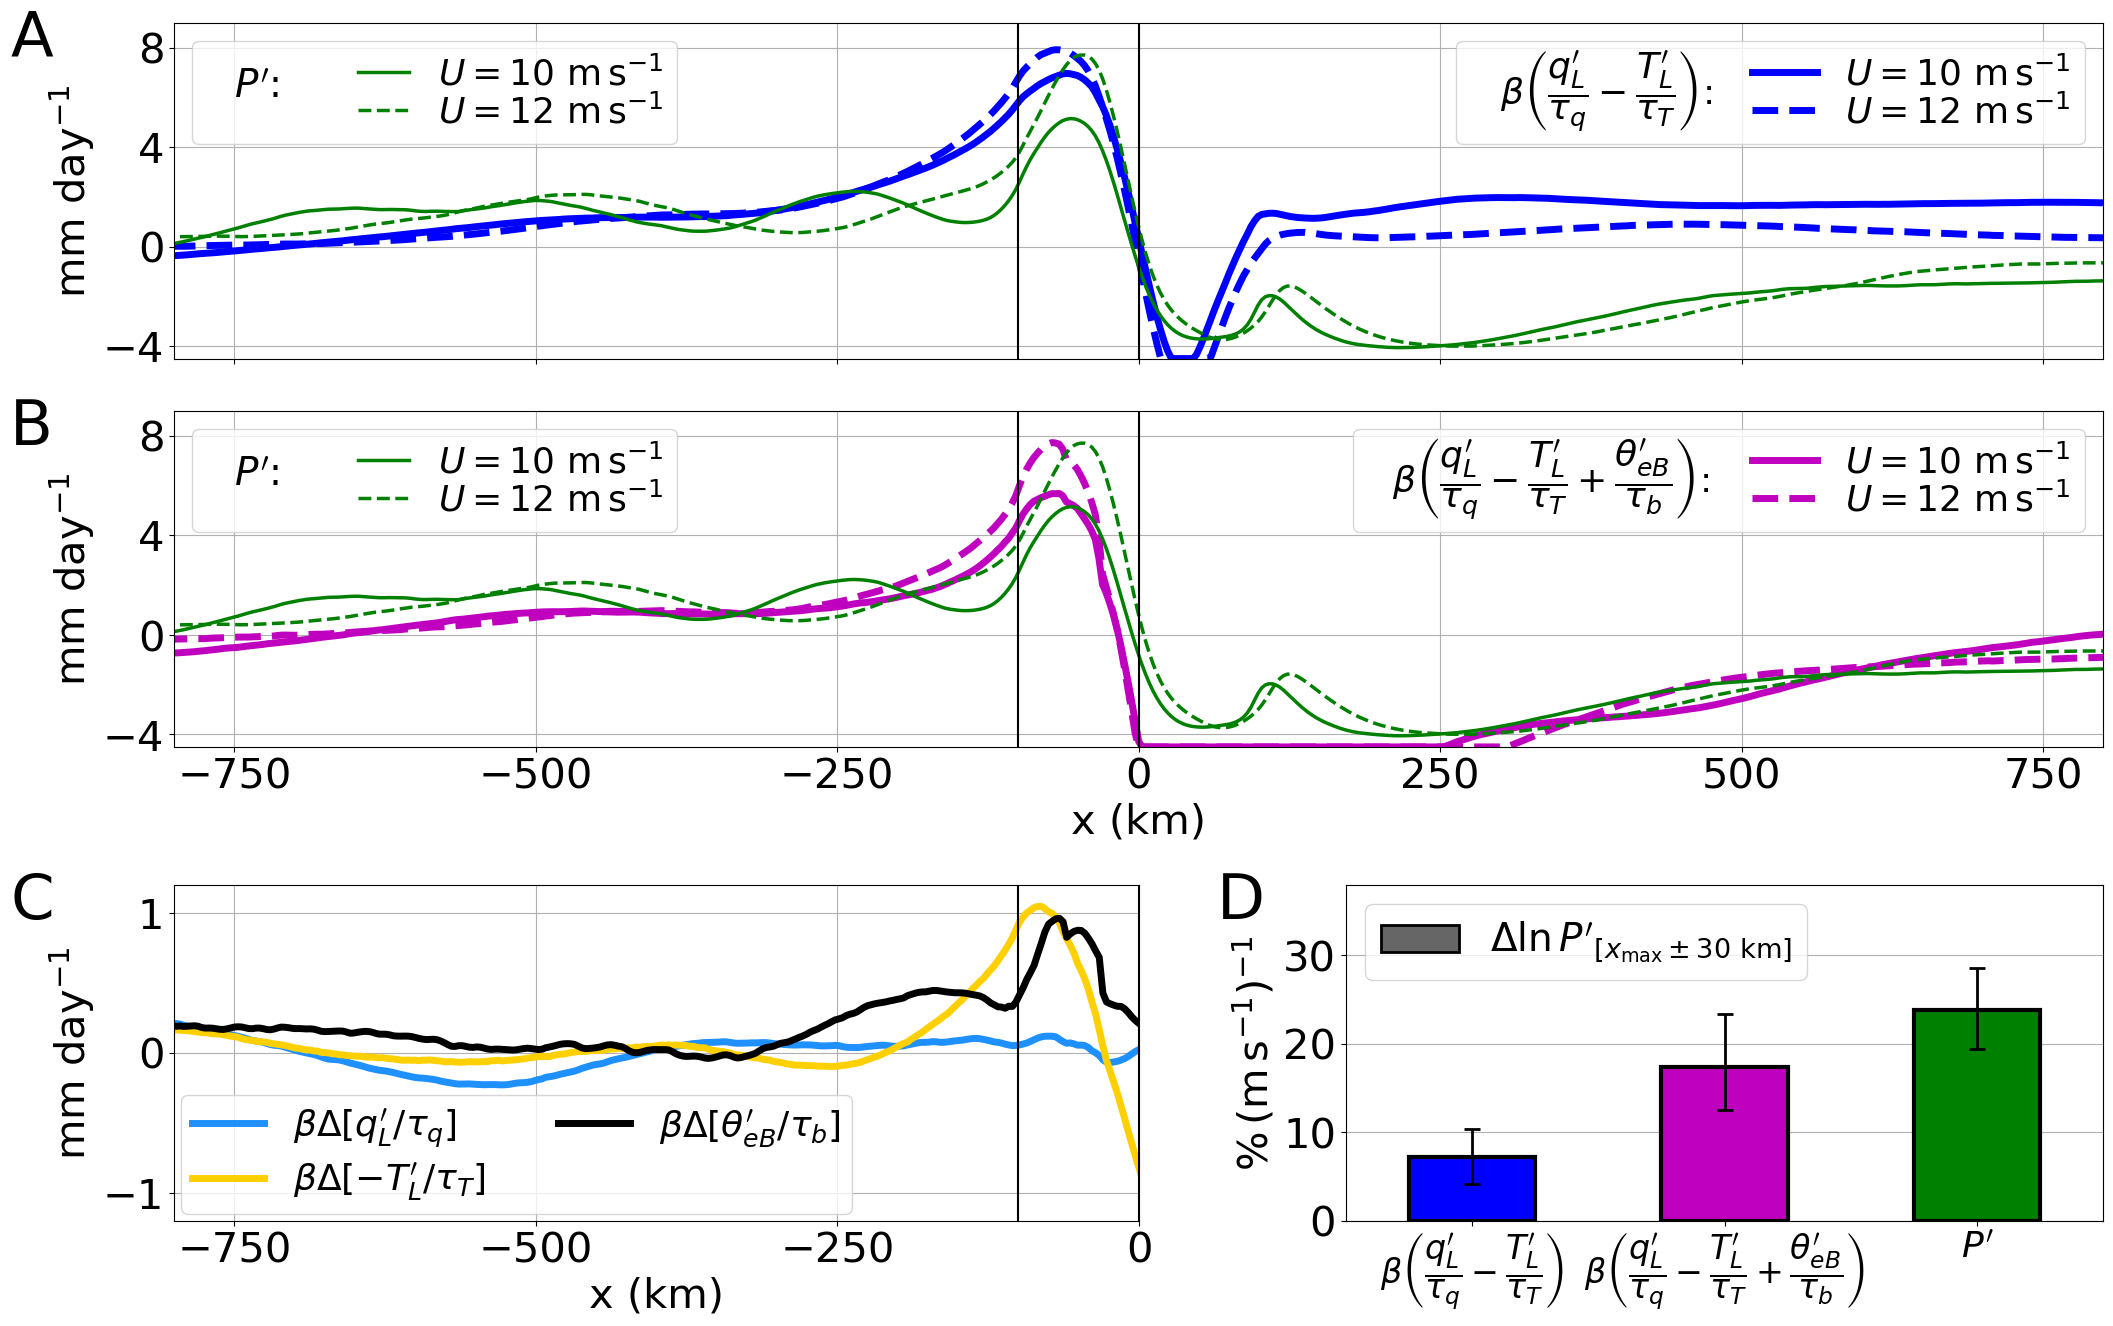

In [28]:
matplotlib.rcParams['hatch.linewidth'] = 4.0
matplotlib.rcParams.update({'font.size': 30})

fig = plt.figure(figsize=(22, 14))
gs = gridspec.GridSpec(nrows=4, ncols=2, height_ratios=[1.,1.,1e-1,1.],width_ratios=[1, 0.785], figure=fig)
ax1 = fig.add_subplot(gs[0, :])
ax2 = fig.add_subplot(gs[1, :])
axnone = fig.add_subplot(gs[2, :])
ax3 = fig.add_subplot(gs[3, 0])  
ax4 = fig.add_subplot(gs[3, 1])  

legend_ftz=26
lw=5
######################################
######## FIRST & SECOND PLOTS ########
######################################
ax1.scatter([0],[0],color='none',label='          ')
ax2.scatter([0],[0],color='none',label='                   ')
ax1.scatter([0],[0],color='none',label='          ')
ax2.scatter([0],[0],color='none',label='                   ')
for i,Sim in enumerate((W10S300, W12S300)):
    lbl1 = Sim.label
    lbl2 = Sim.label
    np.maximum(Sim.Pprime_tq ,-4.5).plot(ax=ax1,linestyle=Sim.lns,color = 'b',linewidth=lw, label=lbl1)
    np.maximum(Sim.Pprime_tqb,-4.5).plot(ax=ax2,linestyle=Sim.lns,color = 'm',linewidth=lw, label=lbl2)
    
for ax in (ax1,ax2):
    ax.set_ylim(-4.5,9)
    ax.set_yticks(range(-4,9,4));
    leg1 = ax.legend(ncol=2,fontsize=legend_ftz, labelspacing=0.05,loc=1,borderpad=0.4,handlelength=1.8)

    line0 =  ax.scatter([0],[0],color='none',label='')
    line02 = ax.scatter([0],[0],color='none',label='')
    line1, = prime(W10S300.RAINNC_MEAN).plot(ax=ax,linestyle = W10S300.lns,color='green',linewidth=lw/2)#Sim.color3
    line2, = prime(W12S300.RAINNC_MEAN).plot(ax=ax,linestyle = W12S300.lns,color='green',linewidth=lw/2)#Sim.color3
    
    leg2 = ax.legend([line0,line02,line1,line2],['','',W10S300.label,W12S300.label], fontsize=legend_ftz, ncol=2, labelspacing=0.05,loc=2,borderpad=0.4,handlelength=1.4)
    
    ax.add_artist(leg1)
    
    ax.text(-750,6.,r"$P'$:",fontsize=legend_ftz+2,zorder=10)
    
    ax.set_ylabel(r'mm day$^{-1}$')

lbl1 = r"$\beta\left(\dfrac{q_L'}{\tau_q}-\dfrac{T_L'}{\tau_T}\right)$"
lbl2 = r"$\beta\left(\dfrac{q_L'}{\tau_q}-\dfrac{T_L'}{\tau_T}+\dfrac{\theta_{eB}'}{\tau_b}\right)$"
ax1.text(300,5.7,lbl1+r':',fontsize=legend_ftz,zorder=10)
ax2.text(210 ,5.7,lbl2+r':',fontsize=legend_ftz,zorder=10)

############################
######## THIRD PLOT ########
############################
ax = ax3
Deltaeb = prime(W12S300.THETAEB_MEAN)-prime(W10S300.THETAEB_MEAN)
DeltaTL = prime(W12S300.TL_MEAN)-prime(W10S300.TL_MEAN)
DeltaqL = (prime(W12S300.QL_MEAN)-prime(W10S300.QL_MEAN))* 2.5e6/1004.

conversion = 1004./2.5e6 * 8000 * 86400

Deltaeb = conversion * Deltaeb/(27.5*3600)
DeltaTL = conversion * DeltaTL/(-7.5*3600)
DeltaqL = conversion * DeltaqL/(27.5*3600)

DeltaqL.plot(ax=ax,color = 'dodgerblue',linewidth=lw, label=r"$\beta\Delta[ q_L'/\tau_q]$")
DeltaTL.plot(ax=ax,color = '#FFD000'   ,linewidth=lw, label=r"$\beta\Delta[- T_L'/\tau_T]$")
Deltaeb.plot(ax=ax,color = 'k'         ,linewidth=lw, label=r"$\beta\Delta[\theta_{eB}'/\tau_b]$")

#ax.fill_between([0,1100],[-20.,-20.],[20.,20.],color='gray',alpha=0.3)
ax.set_ylim(-1.2,1.2)
#ax.set_yticks(np.arange(-0.2,0.21,0.2))
ax.set_xticks(np.arange(-1000,1,250))
ax.legend(fontsize=legend_ftz,loc=3,ncol=2,borderpad = 0.3,borderaxespad = 0.2,labelspacing=0.3)

ax.set_ylabel('mm day$^{-1}$')

############################
######## FOURTH PLOT #######
############################
ax=ax4
# set width of bars
nelems   = 1
nregions = 3
barWidth = 1/(nelems+1)
brs = np.arange(nregions)

#uncertainty_max = np.abs(CIs_max - sens_max[:,None]).T
uncertainty_aroundmax = np.abs(CIs_aroundmax - sens_aroundmax[:,None]).T


colors=['b','m','green']
# draw hatch
ax.bar(brs, sens_aroundmax,yerr = uncertainty_aroundmax, color =colors, width = barWidth, 
       edgecolor='k',linewidth = 3., zorder=3,
       capsize=6,error_kw={'linewidth':2.,'markeredgewidth':2.}
      )  

## For the legend
legend_color="#666666"
ax.bar([-4], [2], color =legend_color, width = barWidth, 
        edgecolor=['k'],linewidth = 2., label = [r"$\Delta\ln P'_{[x_\max \pm 30\text{ km}]}$"])

ax.grid(zorder=0,axis='y')

## Adding Xticks
ax.set_ylabel(r"%$\,\left(\text{m}\,\text{s}^{-1}\right)^{-1}$")

ax.legend(fontsize=legend_ftz+2)
ax.set_xticks([0,1,2])
ax.set_xticklabels([lbl1,lbl2,r"$P'$"])
for tick, size in zip(plt.xticks()[-1], [24,24,26]):
    tick.set_fontsize(size)


D=0.6
ax.set_xlim(-0.5,2.5)
ax.set_ylim(0,38)
ax.set_yticks(range(0,31,10))






############################
###### FINAL TOUCHES #######
############################
for ax,letter in zip((ax1,ax2),('A','B')):
    ax.set_title('')
    ax.text(-0.085,0.9,letter,fontsize=45,transform=ax.transAxes)
for ax,letter in zip((ax3,ax4),('C','D')):
    ax.set_title('')
    ax.text(-0.17,0.9,letter,fontsize=45,transform=ax.transAxes)
    
for ax in ax1,ax2,ax3:
    ax.grid()
    ax.axvline(-100.,color='k')
    ax.axvline(0.,color='k')
    ax.set_xticks(np.arange(-750,751,250))
    
ax1.set_xlim(-800,800)
ax2.set_xlim(-800,800)
ax3.set_xlim(-800,0)
    
    
ax1.set_xlabel('')
ax1.set_xticklabels('')
ax2.set_xlabel('x (km)')
ax3.set_xlabel('x (km)')

fig.align_ylabels()
fig.tight_layout()
fig.subplots_adjust(hspace=0.2,wspace=0.24)
axnone.remove()

fig.savefig('figs/wrf_diags.pdf',format='pdf',bbox_inches='tight')
#fig.savefig('figs/wrf_diags.png',dpi=1000,bbox_inches='tight')


# $\theta_{eB}$ changes

In [11]:
for Sim in W10S300 , W12S300:
    Sim.OMEGA_PL_MEAN = -Sim.T_PL_MEAN.pressure*100/(287. * Sim.T_PL_MEAN) * 9.81 * Sim.W_PL_MEAN
    udthetaedx = -(Sim.U_PL_MEAN*Sim.THETAE_PL_MEAN.differentiate('distance_from_mtn')/1000 * 86400)
    omegadthetaedp = (Sim.OMEGA_PL_MEAN*Sim.THETAE_PL_MEAN.differentiate('pressure')/100 * 86400)
    Qthetae = udthetaedx+omegadthetaedp
    Sim.OMEGADTHETAEDP = omegadthetaedp
    
    omegadthetaedp = (Sim.OMEGA_PL_MEAN*upstream_mean(W10S300.THETAE_PL_MEAN).differentiate('pressure')/100 * 86400)
    Sim.OMEGADTHETAE0DP = omegadthetaedp
    
    Sim.QTHETAE = Qthetae

In [12]:
def smooth(ds):
    return xr.apply_ufunc(gaussian_filter,ds,kwargs={"sigma":2.5})


In [77]:
for Sim in W10S300 , W12S300:
    dthetae0dp = ((upstream_mean(W10S300.THETAE_PL_MEAN) + upstream_mean(W12S300.THETAE_PL_MEAN) )/2).differentiate('pressure')/100
    omegadthetaedp = (Sim.OMEGA_PL_MEAN* dthetae0dp * 86400)
    Sim.OMEGADTHETAE00DP = omegadthetaedp
    

In [78]:
def upblmean(ds):
    return ds.sel(pressure=slice(950,900)).mean('pressure')

In [79]:
from scipy.signal import hilbert
from scipy.integrate import cumtrapz
import scipy.linalg as spl
from orographicPrecipitation.observationsAndERA5.linearWaveModels import z_to_p_standard

def nonlinear_mountain_wave(x,h,z,U,N):
    z2=np.array(z).transpose()[::-1]
    f_L = -np.imag(hilbert(h))
    l=N/U
    H = h+1.j*f_L
    niter=20
    for i in range(niter):
        H = -1j*np.exp(-1j*l*h)*(np.imag(hilbert(np.real(H*np.exp(1j*l*h))))+1j*np.imag(hilbert(np.imag(H*np.exp(1j*l*h)))))
    f=np.imag(H)
    delta = h[:,None]*np.cos(l*(z[None,:]-h[:,None]))+f[:,None]*np.sin(l*(z[None,:]-h[:,None]))
    w=U*np.gradient(delta,x,axis=0)
    # displacement: xr.DataArray(z[None,:]-delta,coords={'x':x,'z':z},dims={'x':x,'z':z})
    return xr.DataArray(w,coords={'distance_from_mtn':x/1000,'altitude':z/1000},dims=['distance_from_mtn','altitude'])

z=np.linspace(0,20e3,200)
xx ,hx = orog.topographic_profile('cos',A=500)
xplot = xx/1e3
xx_ = xx[1000:3001]
hx_ = hx[1000:3001]

w_nonlinear_10=nonlinear_mountain_wave(xx_,hx_,z,10.,1e-2)
w_nonlinear_12=nonlinear_mountain_wave(xx_,hx_,z,12.,1e-2)
p = z_to_p_standard(w_nonlinear_10.altitude*1000)
w_nonlinear_10 = w_nonlinear_10.assign_coords({'pressure':p}).swap_dims({'altitude':'pressure'})
w_nonlinear_12 = w_nonlinear_12.assign_coords({'pressure':p}).swap_dims({'altitude':'pressure'})

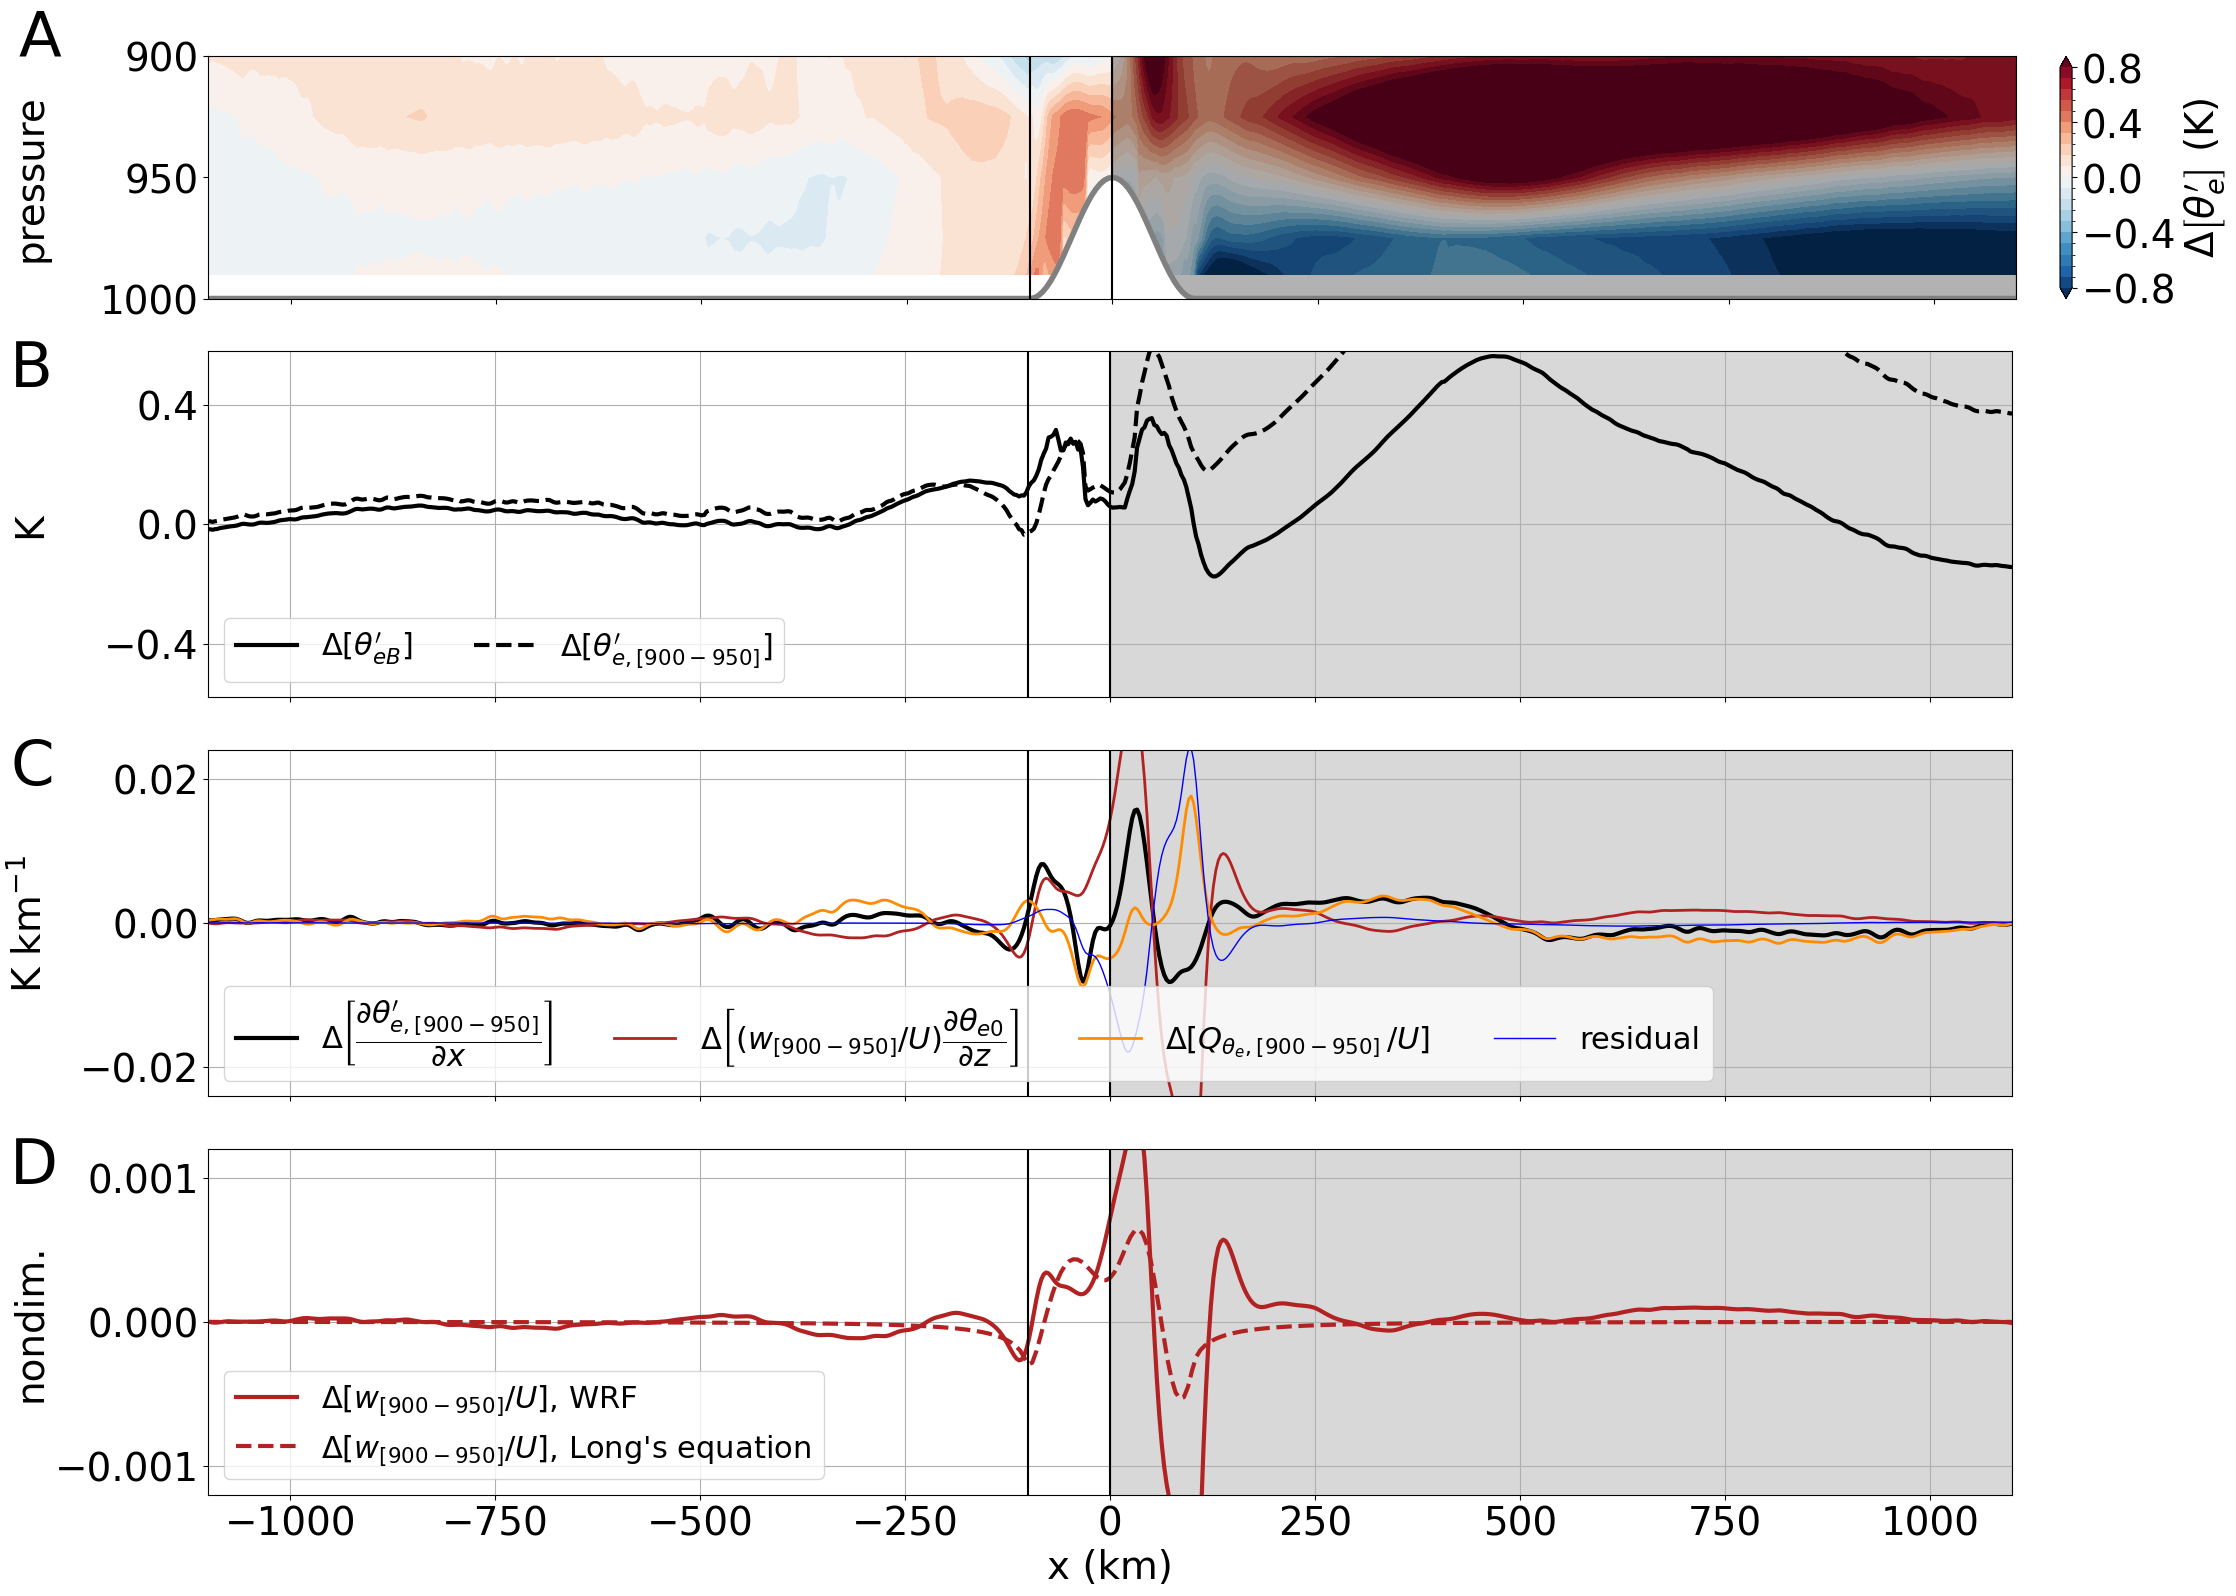

In [81]:
matplotlib.rcParams.update({'font.size': 28})
fig,axs=plt.subplots(4,1,figsize=(24,16),height_ratios = [0.7,1.,1.,1.])

legend_ftz=22

############################
######## FIRST PLOT ########
############################
ax = axs[0]
(prime(W12S300.THETAE_PL_MEAN)-prime(W10S300.THETAE_PL_MEAN)).plot.contourf(ax = axs[0],y='pressure',levels=np.linspace(-0.8,0.8,21),extend='both',yincrease=False,
                                                                      cbar_kwargs={'label':r"$\Delta\left[\theta_e'\right]$ (K)",'pad':0.02,'ticks':np.arange(-0.8,0.81,0.4)}
                                                                     )
ax.fill_between([0,1100],[1000.,1000.],[900.,900.],color='k',alpha=0.3)
ax.fill_between(xplot,1000*xplot**0,1000*xplot**0 - hx*0.1,color='w',zorder=2)
ax.plot(xplot,1000-hx/10,color='gray',linewidth=4)
ax.set_ylim(1000,900)

############################
######## SECOND PLOT ########
############################
ax = axs[1]
#Deltaeb = prime(W12S300.THETAEB_MEAN)-prime(W10S300.THETAEB_MEAN)
Deltaeb = prime(averageB(W12S300.THETAE_PL_MEAN,W12S300.PSFC_MEAN/100,ptop=900)) - prime(averageB(W10S300.THETAE_PL_MEAN,W10S300.PSFC_MEAN/100,ptop=900))

Deltaeb2 = (prime(upblmean(W12S300.THETAE_PL_MEAN))
           -prime(upblmean(W10S300.THETAE_PL_MEAN)))

Deltaeb.plot(ax=ax,color = 'k',linewidth=3, label=r"$\Delta[\theta_{eB}']$")
Deltaeb2.plot(ax=ax,color = 'k',linewidth=3,linestyle='--', label=r"$\Delta[\theta_{e,[900-950]}']$")

ax.fill_between([0,1100],[-20.,-20.],[20.,20.],color='gray',alpha=0.3)
ax.set_ylim(-0.58,0.58)
ax.set_yticks(np.arange(-0.4,0.41,0.4));
ax.legend(fontsize=legend_ftz,loc=3,ncol=3)

ax.set_ylabel('K')

############################
####### THIRD PLOT ########
############################
ax=axs[2]
Delta0 = 1e3*(upblmean(W12S300.THETAE_PL_MEAN).differentiate('distance_from_mtn')/1e3 
             -upblmean(W10S300.THETAE_PL_MEAN).differentiate('distance_from_mtn')/1e3
             )
smooth(Delta0).plot(ax=ax,label = r"$\Delta \left[\dfrac{\partial \theta_{e,[900-950]}'}{\partial x}\right]$",color='k',linewidth=3)

#Delta1 = 1e3*((- W12S300.OMEGADTHETAEDP/86400)/12-(- W10S300.OMEGADTHETAEDP/86400)/10).sel(pressure=925)
Delta1bis = upblmean(1e3*((- W12S300.OMEGADTHETAE0DP/86400)/12-(- W10S300.OMEGADTHETAE0DP/86400)/10))
smooth(Delta1bis).plot(ax=ax,color='firebrick',linewidth=2,label = r"$\Delta \left[(w_{[900-950]}/ U)\dfrac{\partial \theta_{e0}}{\partial z}\right]$")

Delta2 = upblmean(1e3*((W12S300.QTHETAE/86400)/12-(W10S300.QTHETAE/86400)/10))
smooth(Delta2).plot(ax=ax,color='darkorange',linewidth=2,label = r"$\Delta[ Q_{\theta_e,[900-950]} \,/ U]$ ")

(smooth(Delta0)-smooth(Delta1bis)-smooth(Delta2)).plot(ax=ax,color='b',linewidth=1,label = r"residual")


ax.legend(fontsize=legend_ftz,loc=3,ncol=4)
ax.set_ylabel(r"K km$^{-1}$")
ax.fill_between([0,1100],[-1,-1],[1,1],color='gray',alpha=0.3)
ax.set_ylim(-24e-3,24e-3)

#ax2 = ax.twinx()
#(prime(W12S300.THETAE_PL_MEAN.sel(pressure=925))-prime(W10S300.THETAE_PL_MEAN.sel(pressure=925))).plot(ax=ax2,label = r"$\Delta[ \theta_e']$",color='k',linewidth=2,linestyle='--')
#ax2.legend(fontsize=legend_ftz,loc=4)
#ax2.set_ylabel(r"K")
#ax2.set_ylim(-1.1,1.1)


############################
######## FOURTH PLOT ########
############################
ax=axs[3]

smooth(upblmean((W12S300.W_PL_MEAN/12 - W10S300.W_PL_MEAN/10)))    .plot(ax=ax,color='firebrick',linewidth=3,label=r"$\Delta[w_{[900-950]}/U]$, WRF")
upblmean(((w_nonlinear_12/12 - w_nonlinear_10/10))).plot(ax=ax,color='firebrick',linestyle='--',linewidth=3,label=r"$\Delta[w_{[900-950]}/U]$, Long's equation")

ax.legend(fontsize=legend_ftz,loc=3)
ax.fill_between([0,1100],[-20.,-20.],[20.,20.],color='gray',alpha=0.3)

ax.set_ylim(-12e-4,12e-4)
ax.set_ylabel(r"nondim.")

############################
###### FINAL TOUCHES #######
############################

axs[0].text(-0.105,1.,'A',fontsize=45,transform=axs[0].transAxes)
#axs[0].axhline(925.,color='k')
for ax in axs:
    ax.set_title('')
    ax.set_xlim(-1100,1100)
    ax.axvline(-100.,color='k')
    ax.axvline(0.,color='k')
for ax,letter in zip(axs[1:],('B','C','D')):
    ax.grid()
    ax.text(-0.11,0.9,letter,fontsize=45,transform=ax.transAxes)
    divider = make_axes_locatable(ax)
    cax = divider.append_axes("right", size=3.75, pad=0.,axes_class=plt.Axes)
    cax.remove()
    
for ax in axs[:3]:
    ax.set_xlabel('')
    ax.set_xticklabels('')
axs[3].set_xlabel('x (km)')

fig.align_ylabels()
fig.tight_layout(pad=0.3)

fig.savefig('figs/thetaeb.pdf',format='pdf',bbox_inches='tight')

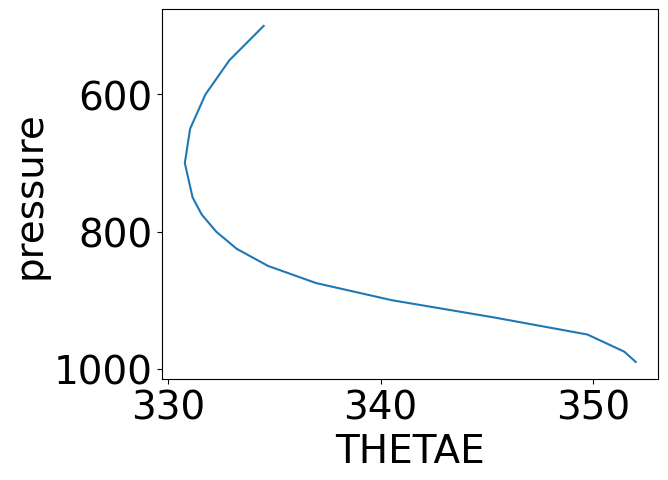

In [156]:
upstream_mean(W12S300.THETAE_PL_MEAN).plot(y='pressure',yincrease=False)

In [157]:
(upstream_mean(W12S300.THETAE_PL_MEAN).differentiate('pressure')/100 * (-upstream_mean(W12S300.RHO_PL_MEAN) * 9.81) * 1000).sel(pressure=925)

<xarray.DataArray ()>
array(-19.805948, dtype=float32)
Coordinates:
    pressure  float32 925.0

# Observations

In [34]:
def plot_regs(axs,MR,dataset,precip_mag=30,regmag=0.1):
    ### DATA
    box_region = MR.box
    rect_region = MR.tilted_rect
    angle = MR.angle
    mask_region = gt.sel_box(dataset.region_masks[MR.name],box_region)
    
    u100 = e5_100u_seasonal_yearly[tuple(MR.months)]
    v100 = e5_100v_seasonal_yearly[tuple(MR.months)]
    precip = dataset.precip_seasonal_yearly[tuple(MR.months)]
    
    u100 = gt.sel_box(u100.sel(year=slice(1960,2015)),box_region)
    v100 = gt.sel_box(v100.sel(year=slice(1960,2015)),box_region)
    precip = gt.sel_box(precip.sel(year=slice(1960,2015)),box_region)
    crossslopeu = gt.crossslopeflow(u100,v100,angle)
    
    mask_wind = mu.tilted_rect(u100,*rect_region,True)
    mask_upstream = mu.tilted_rect_distance(precip,*rect_region[:-1],-2,-4)
    
    aspect=30; pad=0.04; shrink=0.7
    
    ### FIRST PLOT ###
    precip.mean('year').plot.contourf(ax=axs[0],
                                      transform=ccrs.PlateCarree(),
                                      levels=np.linspace(0,30,11),
                                      cmap=plt.cm.GnBu,
                                      cbar_kwargs={'label':r'mm day$^{-1}$','aspect':aspect,'pad':pad,'shrink':shrink}
                                     )
    add_wind(axs[0],u100.mean('year'),v100.mean('year'),width=0.003,scale=200,nm=7,color='k',ref=10,pos=(0.8, 1.03))
    
    ### SECOND PLOT ###
    wind_ts = gt.spatial_mean(crossslopeu,mask = mask_wind)
    precip_reg = gt.linregress_xr(wind_ts,precip,dim='year')
    fdrfact = gt.fdr_xr_2d(precip_reg.pvalue,0.1) * precip_reg.pvalue**0
    (100*precip_reg.slope/precip.mean('year')).plot.contourf(ax=axs[1],
                                                             transform=ccrs.PlateCarree(),
                                                             levels=np.linspace(-30,30,13),
                                                             extend='both',
                                                             cbar_kwargs={'aspect':aspect,'pad':pad,'shrink':shrink,
                                                                          'label':r"%$\,\left(\text{m}\,\text{s}^{-1}\right)^{-1}$"})
    
    hatches = fdrfact.plot.contourf(ax=axs[1], levels=[0.5,1], colors='none', hatches=['','//'], alpha=0,add_colorbar=False)
    
    ### DECORATION ###
    grid_hr = gt.sel_box(MR.vars['IMERG_DAILY'],MR.box)
    mask_wind_hr = mu.tilted_rect(grid_hr,*rect_region,True)
    mask_above_hr = lsm.interp_like(grid_hr) * mu.tilted_rect(grid_hr,*rect_region,False)
    mask_upstream_hr = mu.tilted_rect_distance(grid_hr,*rect_region[:-1],-2,-4)
    
    mask_wind_hr.plot.contour(ax=axs[0],transform=ccrs.PlateCarree(),levels=[0.5],colors='b',linestyles=['--']) 
    mask_above_hr.plot.contour(ax=axs[1],transform=ccrs.PlateCarree(),levels=[0.5],colors='k',linestyles=['--'],linewidths=[1.5])
    mask_upstream_hr.plot.contour(ax=axs[1],transform=ccrs.PlateCarree(),levels=[0.5],colors='k',linestyles=['-']) 
    for ax in axs:
        smooth(gt.sel_box(topo_hires,box_region)).plot.contour(ax=ax,levels=[500.],colors='#555555',linewidths=[1.])
        ax.coastlines(linewidth=2)
        ax.set_xlim(box_region[0],box_region[1])
        ax.set_ylim(box_region[2],box_region[3])
        add_latlon(ax,box_region,ftz=28)

In [35]:
def detrend_xr(da):
    # Calculate the linear trend
    trend = da.polyfit(dim='year', deg=1)
    
    # Extract the slope and intercept of the linear trend
    slope = trend.polyfit_coefficients[0]
    intercept = trend.polyfit_coefficients[1]
    
    # Create a time series of the trend
    trend_ts = slope * da.year + intercept
    
    # Detrend the original time series by subtracting the trend
    return da - trend_ts

In [36]:
def get_sensitivity(MR,dataset,option = 0,detrend=False):
    ### DATA
    box_region = MR.box
    rect_region = MR.tilted_rect
    angle = MR.angle
    mask_region = gt.sel_box(dataset.region_masks[MR.name],box_region)
    
    u100 = e5_100u_seasonal_yearly[tuple(MR.months)]
    v100 = e5_100v_seasonal_yearly[tuple(MR.months)]
    precip = dataset.precip_seasonal_yearly[tuple(MR.months)]
    
    u100 = gt.sel_box(u100.sel(year=slice(1960,2015)),box_region)
    v100 = gt.sel_box(v100.sel(year=slice(1960,2015)),box_region)
    precip = gt.sel_box(precip.sel(year=slice(1960,2015)),box_region)
    crossslopeu = gt.crossslopeflow(u100,v100,angle)
    
    mask_wind = mu.tilted_rect(u100,*rect_region,True)
    mask_upstream = mu.tilted_rect_distance(precip,*rect_region[:-1],-2,-4)
    
     ### Get sensitivity with bounds
    wind_ts = gt.spatial_mean(crossslopeu,mask = mask_wind)
    precip_ts = gt.spatial_mean(precip,mask = mask_region)
    if detrend:
        wind_ts = wind_ts.mean()+detrend_xr(wind_ts)
        precip_ts = precip_ts.mean()+detrend_xr(precip_ts)
    
    if option==0 or option == 1:
        slope0 = gt.linregress_xr(wind_ts,precip_ts,dim='year').slope
        joint_sample = gt.generate_joint_sample(np.vstack((wind_ts.data, precip_ts.data)),blocksize=1,nbootstrap=100000)
        wind_sample = xr.DataArray(joint_sample[0],dims = ['bootstrap','year'])
        precip_sample = xr.DataArray(joint_sample[1],dims = ['bootstrap','year'])
        slope_sample = gt.linregress_xr(wind_sample,precip_sample,dim='year').slope
        
        if option==0:
            sensitivity0 = 100* slope0 / precip_ts.mean('year')
            sensitivity_sample = 100* slope_sample / precip_sample.mean('year')
            print("P",end=' ')
        elif option==1:
            sensitivity0 = 100* slope0 / (precip_ts-MR.P0).mean('year')
            sensitivity_sample = 100* slope_sample / (precip_sample-MR.P0).mean('year')
            print("Using P0 = %i mm/day: P'"%MR.P0,end=' ')
    elif option==2:
        precip_ts_upstream = gt.spatial_mean(precip,mask = mask_upstream)
        if detrend:
            precip_ts_upstream = precip_ts_upstream.mean()+detrend_xr(precip_ts_upstream)
        slope0 = gt.linregress_xr(wind_ts,precip_ts-precip_ts_upstream,dim='year').slope
        sensitivity0 = 100* slope0 / (precip_ts-precip_ts_upstream).mean('year')
        
        joint_sample = gt.generate_joint_sample(np.vstack((wind_ts.data, precip_ts.data,precip_ts_upstream.data)),blocksize=1,nbootstrap=100000)
        wind_sample = xr.DataArray(joint_sample[0],dims = ['bootstrap','year'])
        pprime_sample = xr.DataArray(joint_sample[1]-joint_sample[2],dims = ['bootstrap','year'])
        slope_sample = gt.linregress_xr(wind_sample,pprime_sample,dim='year').slope
        sensitivity_sample = 100* slope_sample / pprime_sample.mean('year')
        print("Calculating P0 200-400km upstream: P'", end=' ')

    sens, upper, lower = (sensitivity0, np.quantile(sensitivity_sample,0.025),np.quantile(sensitivity_sample,0.975))
    print("sensitivity: %.1f [%.1f - %.1f] %% / (m/s)"%(sens, upper, lower))
    return sens, upper, lower

def get_sensitivity_daily(MR):
    ### DATA
    angle = MR.angle

    ### Get sensitivity with bounds
    wind_ts = gt.crossslopeflow(MR.vars['U100_DAILY_BOXWIND'],MR.vars['V100_DAILY_BOXWIND'],angle)
    precip_ts = MR.vars['IMERG_DAILY_ABOVE'] 
    precip_ts_upstream = MR.vars['IMERG_DAILY_UPSTREAM']

    slope0 = gt.linregress_xr(wind_ts,precip_ts-precip_ts_upstream,dim='time').slope
    sensitivity0 = 100* slope0 / (precip_ts-precip_ts_upstream).mean('time')
    
    joint_sample = gt.generate_joint_sample(np.vstack((wind_ts.data, precip_ts.data,precip_ts_upstream.data)),blocksize=1,nbootstrap=10000)
    wind_sample = xr.DataArray(joint_sample[0],dims = ['bootstrap','time'])
    pprime_sample = xr.DataArray(joint_sample[1]-joint_sample[2],dims = ['bootstrap','time'])
    slope_sample = gt.linregress_xr(wind_sample,pprime_sample,dim='time').slope
    sensitivity_sample = 100* slope_sample / pprime_sample.mean('time')
    print("Calculating P0 200-400km upstream: P'", end=' ')

    sens, upper, lower = (sensitivity0, np.quantile(sensitivity_sample,0.025),np.quantile(sensitivity_sample,0.975))
    print("sensitivity: %.1f [%.1f - %.1f] %% / (m/s)"%(sens, upper, lower))
    return sens, upper, lower

In [37]:
sensitivities = np.zeros((len(MRs),3,3))
for i,MR in enumerate(MRs):
    for j,DS in enumerate([APHRODITE,ERA5]):
        option=(j==1) * 2
        sensitivities[i,j] = get_sensitivity(MR,DS,option=option)
    sensitivities[i,2] = get_sensitivity_daily(MR)

P sensitivity: 15.1 [4.5 - 21.2] % / (m/s)
Calculating P0 200-400km upstream: P' sensitivity: 25.4 [15.2 - 32.5] % / (m/s)
Calculating P0 200-400km upstream: P' sensitivity: 31.7 [29.0 - 34.8] % / (m/s)
P sensitivity: 14.5 [9.9 - 19.0] % / (m/s)
Calculating P0 200-400km upstream: P' sensitivity: 32.8 [21.8 - 46.6] % / (m/s)
Calculating P0 200-400km upstream: P' sensitivity: 34.1 [28.6 - 40.8] % / (m/s)
P sensitivity: 14.5 [5.4 - 24.9] % / (m/s)
Calculating P0 200-400km upstream: P' sensitivity: 30.9 [15.9 - 47.8] % / (m/s)
Calculating P0 200-400km upstream: P' sensitivity: 22.4 [14.1 - 33.7] % / (m/s)
P sensitivity: 4.1 [-5.4 - 12.7] % / (m/s)
Calculating P0 200-400km upstream: P' sensitivity: 26.0 [5.8 - 48.5] % / (m/s)
Calculating P0 200-400km upstream: P' sensitivity: 17.1 [11.0 - 23.6] % / (m/s)
P sensitivity: -1.8 [-8.0 - 4.1] % / (m/s)
Calculating P0 200-400km upstream: P' sensitivity: 20.9 [3.7 - 38.2] % / (m/s)
Calculating P0 200-400km upstream: P' sensitivity: 21.2 [18.0 - 24.

/global/common/software/m3310/conda/xrdask.2023.11.qn/lib/python3.9/site-packages/xarray/core/computation.py:761: RuntimeWarning: invalid value encountered in sqrt
  result_data = func(*input_data)
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.


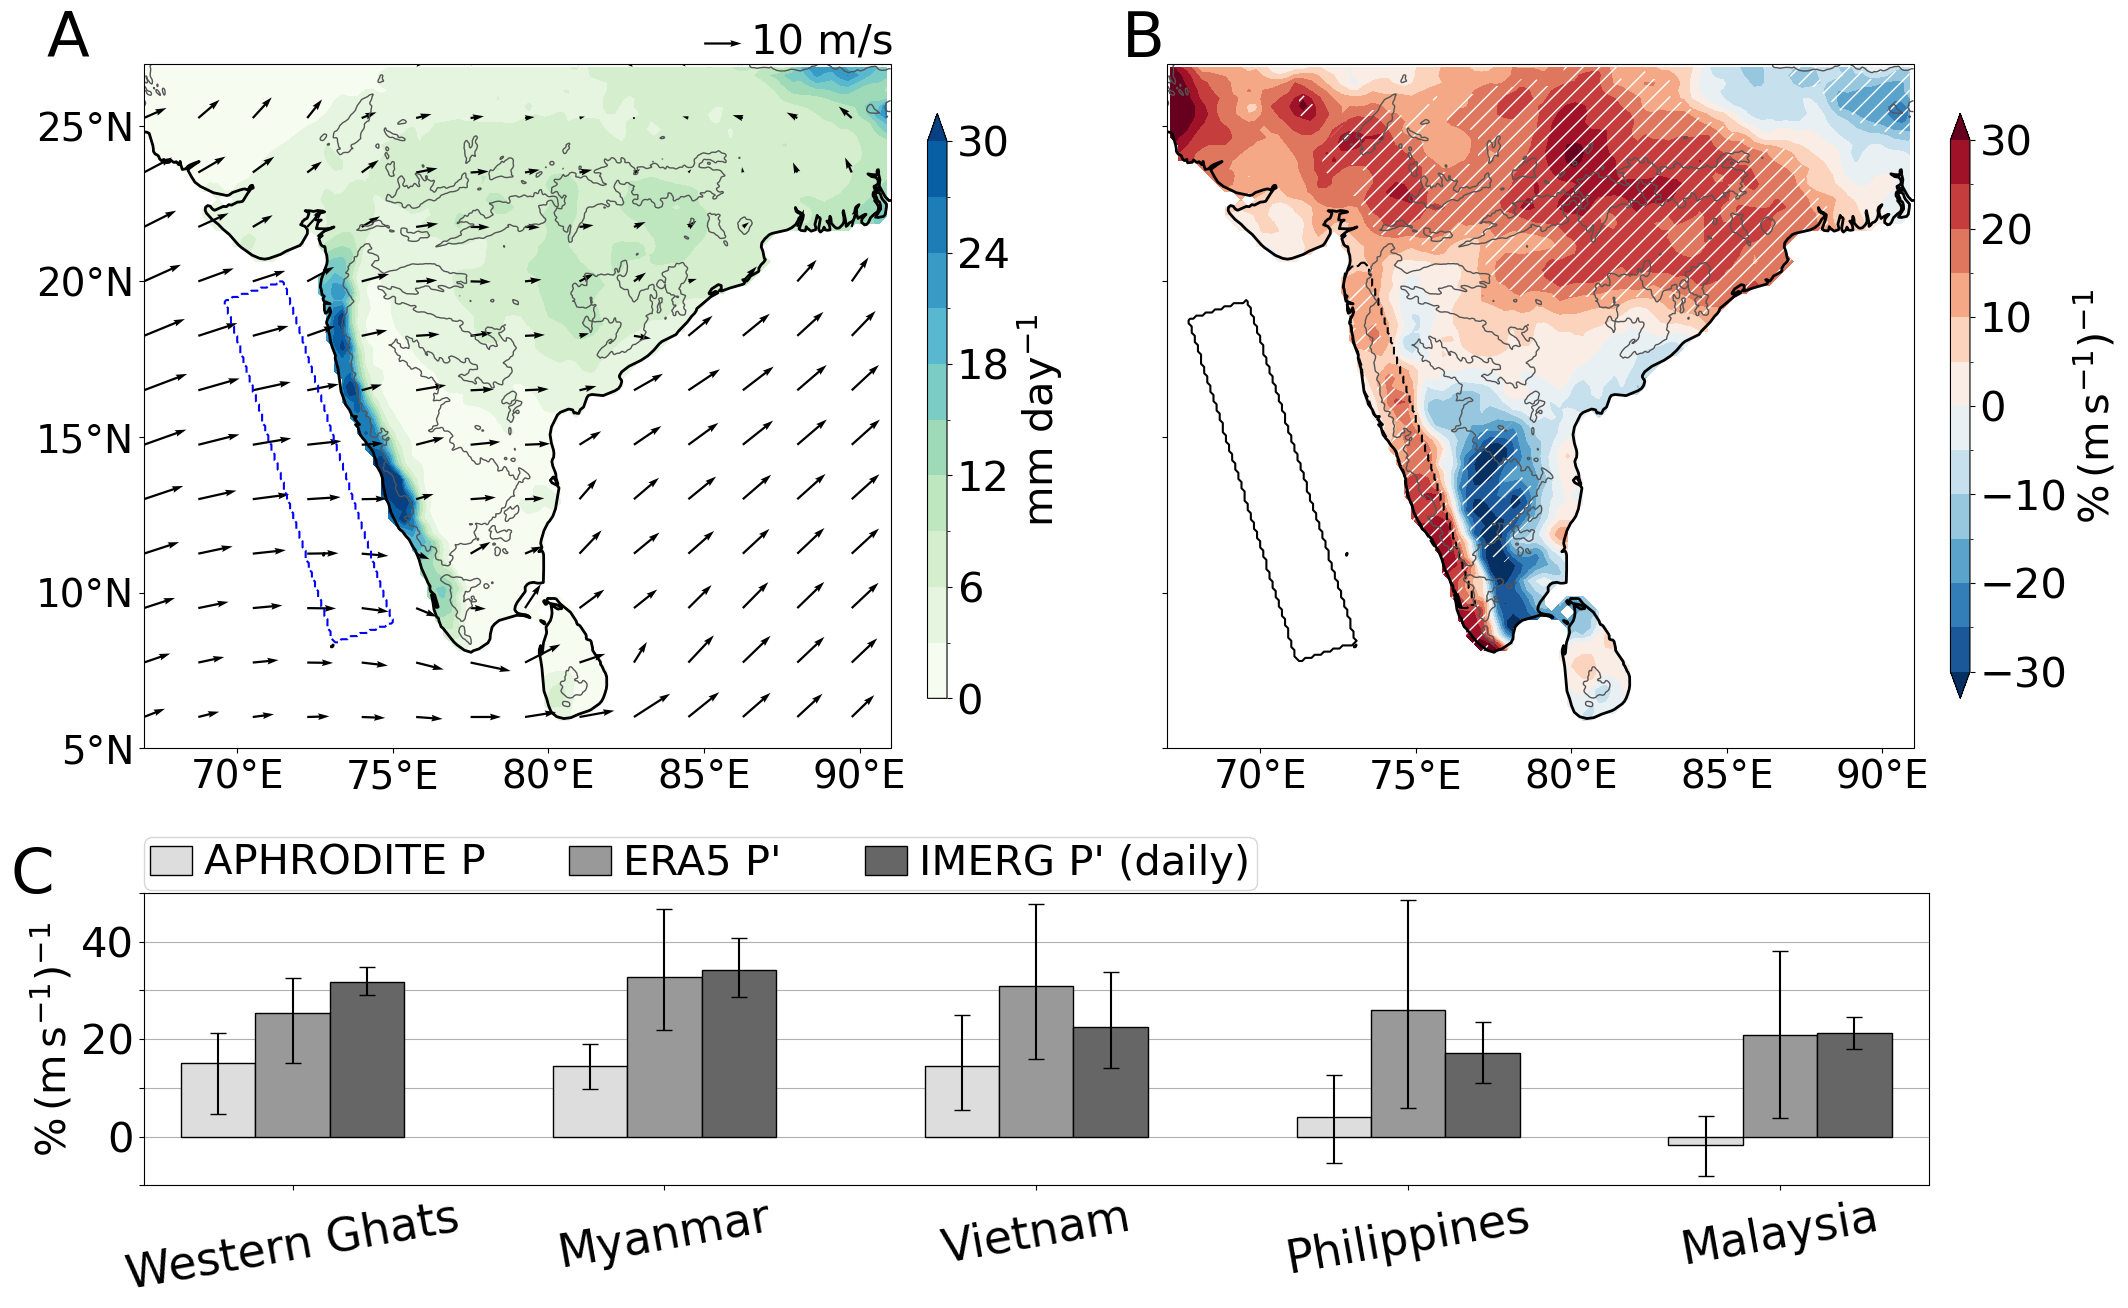

In [39]:
matplotlib.rcParams.update({'font.size':30})
plt.rcParams['hatch.color'] = 'w'
matplotlib.rcParams['hatch.linewidth'] = 1.0

# Create a figure and a set of subplots
fig = plt.figure(figsize=(22, 14))
gs = gridspec.GridSpec(nrows=2, ncols=2, height_ratios=[2, 0.7], figure=fig)
ax1 = fig.add_subplot(gs[0, 0], projection=ccrs.PlateCarree())
ax2 = fig.add_subplot(gs[0, 1], projection=ccrs.PlateCarree())
ax3 = fig.add_subplot(gs[1, :])  

# The first row has two panels, each using a cartopy projection PlateCarree
plot_regs([ax1,ax2],Ghats,APHRODITE)

###### Make bar plot ###### 
# set width of bars
nelems   = 3
nregions = len(MRs)
barWidth = 1/(nelems+2)
#colors = ['#FFB000','darkorange','firebrick']
colors = ['#DDDDDD','#999999','#666666']
labels = [r"APHRODITE P",r"ERA5 P'",r"IMERG P' (daily)"]

# Set position of bar on X axis & plot bar
brs = np.arange(nregions)
for i in range(nelems):
    ax3.bar(brs + i*barWidth, sensitivities[:,i,0], color =colors[i], width = barWidth,
            edgecolor ='k', label = labels[i], yerr=np.abs(sensitivities[:,i,1:]-sensitivities[:,i,:1]).T, zorder=3,capsize=6,error_kw={'linewidth':1.5})    

# Adding Xticks
ax3.set_ylabel(r"%$\,\left(\text{m}\,\text{s}^{-1}\right)^{-1}$")
ax3.set_xticks([r + (nelems-1)/2*barWidth for r in range(nregions)],[MR.Lname for MR in MRs],rotation=10)
ax3.tick_params(axis='x', labelsize=33)

handles, labels = ax3.get_legend_handles_labels()
order = [0,1,2]
#ax3.legend([handles[idx] for idx in order],[labels[idx] for idx in order],handlelength=1,borderpad=0.15,borderaxespad=0.1,handletextpad=0.3,ncol=3,columnspacing=2,loc=3)
ax3.legend([handles[idx] for idx in order],[labels[idx] for idx in order],handlelength=1,borderpad=0.15,handletextpad=0.3,ncol=3,columnspacing=2,loc=(0.,1.01))

ax3.grid(zorder=0,axis='y')
ax3.set_ylim(-10,50)
ax3.set_yticks(range(-10,51,10))
ax3.set_yticklabels(['','0','','20','','40',''])
ax3.set_xlim(-0.2,4.6)

divider = make_axes_locatable(ax3)
cax = divider.append_axes("right", size=1., pad=.6,axes_class=plt.Axes)
cax.remove()
###### ###### ###### ###### ###### 

for ax in ax1,ax2,ax3:
    ax.set_title('')
ax1.text(-0.13,1.01,'A',fontsize=45,transform=ax1.transAxes)
ax2.text(-0.06,1.01,'B',fontsize=45,transform=ax2.transAxes)
ax3.text(-0.075,1.,'C',fontsize=45,transform=ax3.transAxes)
ax2.set_yticklabels('')

fig.tight_layout(h_pad=1.)

fig.savefig('figs/obs_regs.pdf',format='pdf',bbox_inches='tight')


# CMIP

mean = -0.49 / std = 0.29 / mean(abs) = 0.50
mean = 0.21 / std = 0.58 / mean(abs) = 0.52
mean = 0.04 / std = 0.32 / mean(abs) = 0.26
mean = 0.07 / std = 0.49 / mean(abs) = 0.42
mean = 0.20 / std = 0.36 / mean(abs) = 0.33


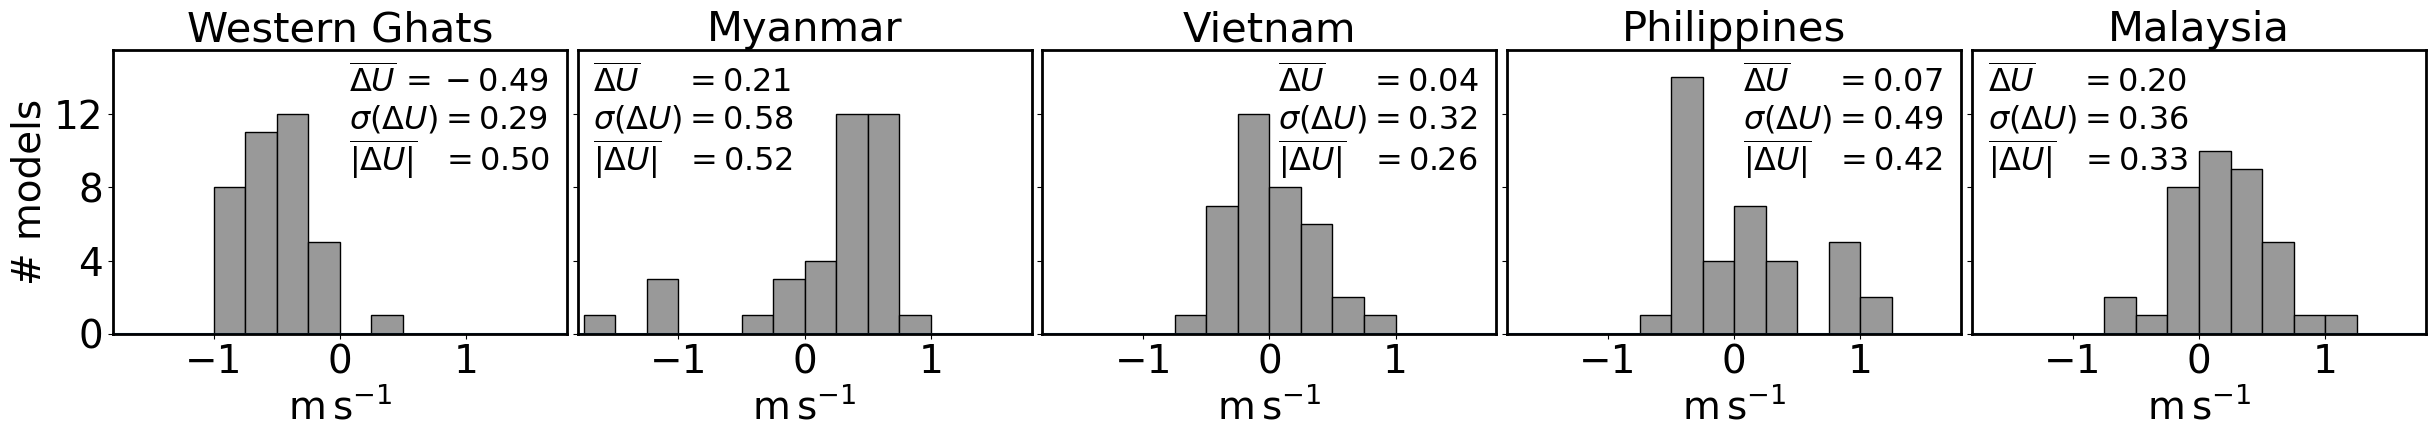

In [20]:
matplotlib.rcParams.update({'font.size':28})
fig,axs=plt.subplots(1,5,figsize=(25,5))

for i,(ax,MR) in enumerate(zip(axs,MRs)):
    uperp_diff = [MR.ssp5_uperps_boxmean[k] - MR.hist_uperps_boxmean[k] for k in MR.valid_models]
    ax.hist(uperp_diff,bins=np.arange(-2,2.1,0.25),color='#999999',edgecolor ='k')
    ax.set_title(MR.Lname,fontsize=30)
    ax.axhline()
    print("mean = %.2f / std = %.2f / mean(abs) = %.2f"%(np.mean(uperp_diff),np.std(uperp_diff),np.mean(np.abs(uperp_diff))))
    
    ax.set_xlabel(r'm$\,$s$^{-1}$')
    ax.set_ylabel('# models')
    
    ax.set_ylim(0,15.5)
    ax.set_yticks(range(0,15,4))
    #ax.set_yticklabels(['0','','4','','8','','12',''])
    ax.set_xlim(-1.8,1.8)
    ax.set_xticks((-1,0,1))
    
    top=0.85
    delta=0.14
    if i==1 or i==4:
        x0=0.035
    else:
        x0=0.52
    if i>0:
        ax.text(x0,top          ,r"$\overline{\Delta U}~~~\;\, = %.2f$"%np.mean(uperp_diff)    ,fontsize=23,transform = ax.transAxes)
    else:
        ax.text(x0,top          ,r"$\overline{\Delta U}\, = %.2f$"%np.mean(uperp_diff)         ,fontsize=23,transform = ax.transAxes)
    ax.text(x0,top-delta*0.9,r"$\sigma(\Delta U) = %.2f$"          %np.std(uperp_diff)         ,fontsize=23,transform = ax.transAxes)
    ax.text(x0,top-delta*2  ,r"$\overline{|\Delta U|} ~\;\,= %.2f$"%np.mean(np.abs(uperp_diff)),fontsize=23,transform = ax.transAxes)
    
    for spine in ['left', 'right', 'top', 'bottom']:
        ax.spines[spine].set_linewidth(2)
    
for ax in axs[1:]:
    ax.set_ylabel('')
    ax.set_yticklabels('')
fig.tight_layout(w_pad=-.9)

fig.savefig('figs/cmipwind.pdf',format='pdf',bbox_inches='tight')

# SI Figure - all regions

In [32]:
def plot_precip(ax,MR,dataset,precip_mag=30):
    ### DATA
    box_region = MR.box
    rect_region = MR.tilted_rect
    
    u100 = e5_100u_seasonal_yearly[tuple(MR.months)]
    v100 = e5_100v_seasonal_yearly[tuple(MR.months)]
    precip = dataset.precip_seasonal_yearly[tuple(MR.months)]
    
    u100 = gt.sel_box(u100.sel(year=slice(1960,2015)),box_region)
    v100 = gt.sel_box(v100.sel(year=slice(1960,2015)),box_region)
    precip = gt.sel_box(precip.sel(year=slice(1960,2015)),box_region)

    aspect=30; pad=0.04; shrink=0.8
    
    ### FIRST PLOT ###
    precip.mean('year').plot.contourf(ax=ax,
                                      transform=ccrs.PlateCarree(),
                                      levels=np.linspace(0,precip_mag,11),
                                      cmap=plt.cm.GnBu,
                                      cbar_kwargs={'label':r'mm day$^{-1}$','aspect':aspect,'pad':pad,'shrink':shrink}
                                     )
    add_wind(ax,u100.mean('year'),v100.mean('year'),width=0.003,scale=200,nm=7,color='k',ref=10,pos=(0.83, 1.03))
    
    
    ### DECORATION ###
    grid_hr = gt.sel_box(MR.vars['IMERG_DAILY'],MR.box)
    mask_wind_hr = mu.tilted_rect(grid_hr,*rect_region,True)
    mask_wind_hr.plot.contour(ax=ax,transform=ccrs.PlateCarree(),levels=[0.5],colors='b',linestyles=['--']) 
    
    smooth(gt.sel_box(topo_hires,box_region)).plot.contour(ax=ax,levels=[500.],colors='#555555',linewidths=[1.])
    ax.coastlines(linewidth=2)
    ax.set_xlim(box_region[0],box_region[1])
    ax.set_ylim(box_region[2],box_region[3])
    add_latlon(ax,box_region)
        
def plot_reg(ax,MR,dataset,regmag=0.1):
    ### DATA
    box_region = MR.box
    rect_region = MR.tilted_rect
    angle = MR.angle
    mask_region = gt.sel_box(dataset.region_masks[MR.name],box_region)
    
    u100 = e5_100u_seasonal_yearly[tuple(MR.months)]
    v100 = e5_100v_seasonal_yearly[tuple(MR.months)]
    precip = dataset.precip_seasonal_yearly[tuple(MR.months)]
    
    u100 = gt.sel_box(u100.sel(year=slice(1960,2015)),box_region)
    v100 = gt.sel_box(v100.sel(year=slice(1960,2015)),box_region)
    precip = gt.sel_box(precip.sel(year=slice(1960,2015)),box_region)
    crossslopeu = gt.crossslopeflow(u100,v100,angle)
    
    mask_wind = mu.tilted_rect(u100,*rect_region,True)
    mask_upstream = mu.tilted_rect_distance(precip,*rect_region[:-1],-2,-4)
    
    aspect=30; pad=0.04; shrink=0.8
    
    ### SECOND PLOT ###
    wind_ts = gt.spatial_mean(crossslopeu,mask = mask_wind)
    precip_reg = gt.linregress_xr(wind_ts,precip,dim='year')
    fdrfact = gt.fdr_xr_2d(precip_reg.pvalue,0.1) * precip_reg.pvalue**0
    (100*precip_reg.slope/precip.mean('year')).plot.contourf(ax=ax,
                                                             transform=ccrs.PlateCarree(),
                                                             levels=np.linspace(-30,30,13),
                                                             extend='both',
                                                             cbar_kwargs={'aspect':aspect,'pad':pad,'shrink':shrink,
                                                                          'label':r"%$\,\left(\text{m}\,\text{s}^{-1}\right)^{-1}$"})
    
    hatches = fdrfact.plot.contourf(ax=ax, levels=[0.5,1], colors='none', hatches=['','//'], alpha=0,add_colorbar=False)
    
    ### DECORATION ###
    grid_hr = gt.sel_box(MR.vars['IMERG_DAILY'],MR.box)
    mask_above_hr = lsm.interp_like(grid_hr) * mu.tilted_rect(grid_hr,*rect_region,False)
    mask_upstream_hr = mu.tilted_rect_distance(grid_hr,*rect_region[:-1],-2,-4)
    
    mask_above_hr.plot.contour(ax=ax,transform=ccrs.PlateCarree(),levels=[0.5],colors='k',linestyles=['--'],linewidths=[1.5])
    mask_upstream_hr.plot.contour(ax=ax,transform=ccrs.PlateCarree(),levels=[0.5],colors='k',linestyles=['-']) 

    smooth(gt.sel_box(topo_hires,box_region)).plot.contour(ax=ax,levels=[500.],colors='#555555',linewidths=[1.])
    ax.coastlines(linewidth=2)
    ax.set_xlim(box_region[0],box_region[1])
    ax.set_ylim(box_region[2],box_region[3])
    add_latlon(ax,box_region)
    
def plot_reg_daily(ax,MR,regmag=0.1):
    ### DATA
    box_region = MR.box
    rect_region = MR.tilted_rect
    angle = MR.angle
    precip = MR.vars['IMERG_DAILY'].transpose('time','latitude','longitude')

    aspect=30; pad=0.04; shrink=0.8
    
    ### SECOND PLOT ###
    wind_ts = gt.crossslopeflow(MR.vars['U100_DAILY_BOXWIND'],MR.vars['V100_DAILY_BOXWIND'],angle)
    precip_reg = gt.linregress_xr(wind_ts,precip,dim='time')
    fdrfact = gt.fdr_xr_2d(precip_reg.pvalue,0.1) * precip_reg.pvalue**0
    (100*precip_reg.slope/precip.mean('time')).plot.contourf(ax=ax,
                                                             transform=ccrs.PlateCarree(),
                                                             levels=np.linspace(-30,30,13),
                                                             extend='both',
                                                             cbar_kwargs={'aspect':aspect,'pad':pad,'shrink':shrink,
                                                                          'label':r"%$\,\left(\text{m}\,\text{s}^{-1}\right)^{-1}$"})
    
    hatches = fdrfact.plot.contourf(ax=ax, levels=[0.5,1], colors='none', hatches=['','//'], alpha=0,add_colorbar=False)
    
    ### DECORATION ###
    grid_hr = gt.sel_box(MR.vars['IMERG_DAILY'],MR.box)
    mask_above_hr = lsm.interp_like(grid_hr) * mu.tilted_rect(grid_hr,*rect_region,False)
    mask_upstream_hr = mu.tilted_rect_distance(grid_hr,*rect_region[:-1],-2,-4)
    
    mask_above_hr.plot.contour(ax=ax,transform=ccrs.PlateCarree(),levels=[0.5],colors='k',linestyles=['--'],linewidths=[1.5])
    mask_upstream_hr.plot.contour(ax=ax,transform=ccrs.PlateCarree(),levels=[0.5],colors='k',linestyles=['-']) 

    smooth(gt.sel_box(topo_hires,box_region)).plot.contour(ax=ax,levels=[500.],colors='#555555',linewidths=[1.])
    ax.coastlines(linewidth=2)
    ax.set_xlim(box_region[0],box_region[1])
    ax.set_ylim(box_region[2],box_region[3])
    add_latlon(ax,box_region)
    

/global/common/software/m3310/conda/xrdask.2023.11.qn/lib/python3.9/site-packages/xarray/core/computation.py:761: RuntimeWarning: invalid value encountered in sqrt
  result_data = func(*input_data)
/global/common/software/m3310/conda/xrdask.2023.11.qn/lib/python3.9/site-packages/xarray/core/computation.py:761: RuntimeWarning: invalid value encountered in sqrt
  result_data = func(*input_data)
/global/common/software/m3310/conda/xrdask.2023.11.qn/lib/python3.9/site-packages/xarray/core/computation.py:761: RuntimeWarning: invalid value encountered in sqrt
  result_data = func(*input_data)
/global/common/software/m3310/conda/xrdask.2023.11.qn/lib/python3.9/site-packages/xarray/core/computation.py:761: RuntimeWarning: invalid value encountered in sqrt
  result_data = func(*input_data)
/global/common/software/m3310/conda/xrdask.2023.11.qn/lib/python3.9/site-packages/xarray/core/computation.py:761: RuntimeWarning: invalid value encountered in sqrt
  result_data = func(*input_data)
/global/co

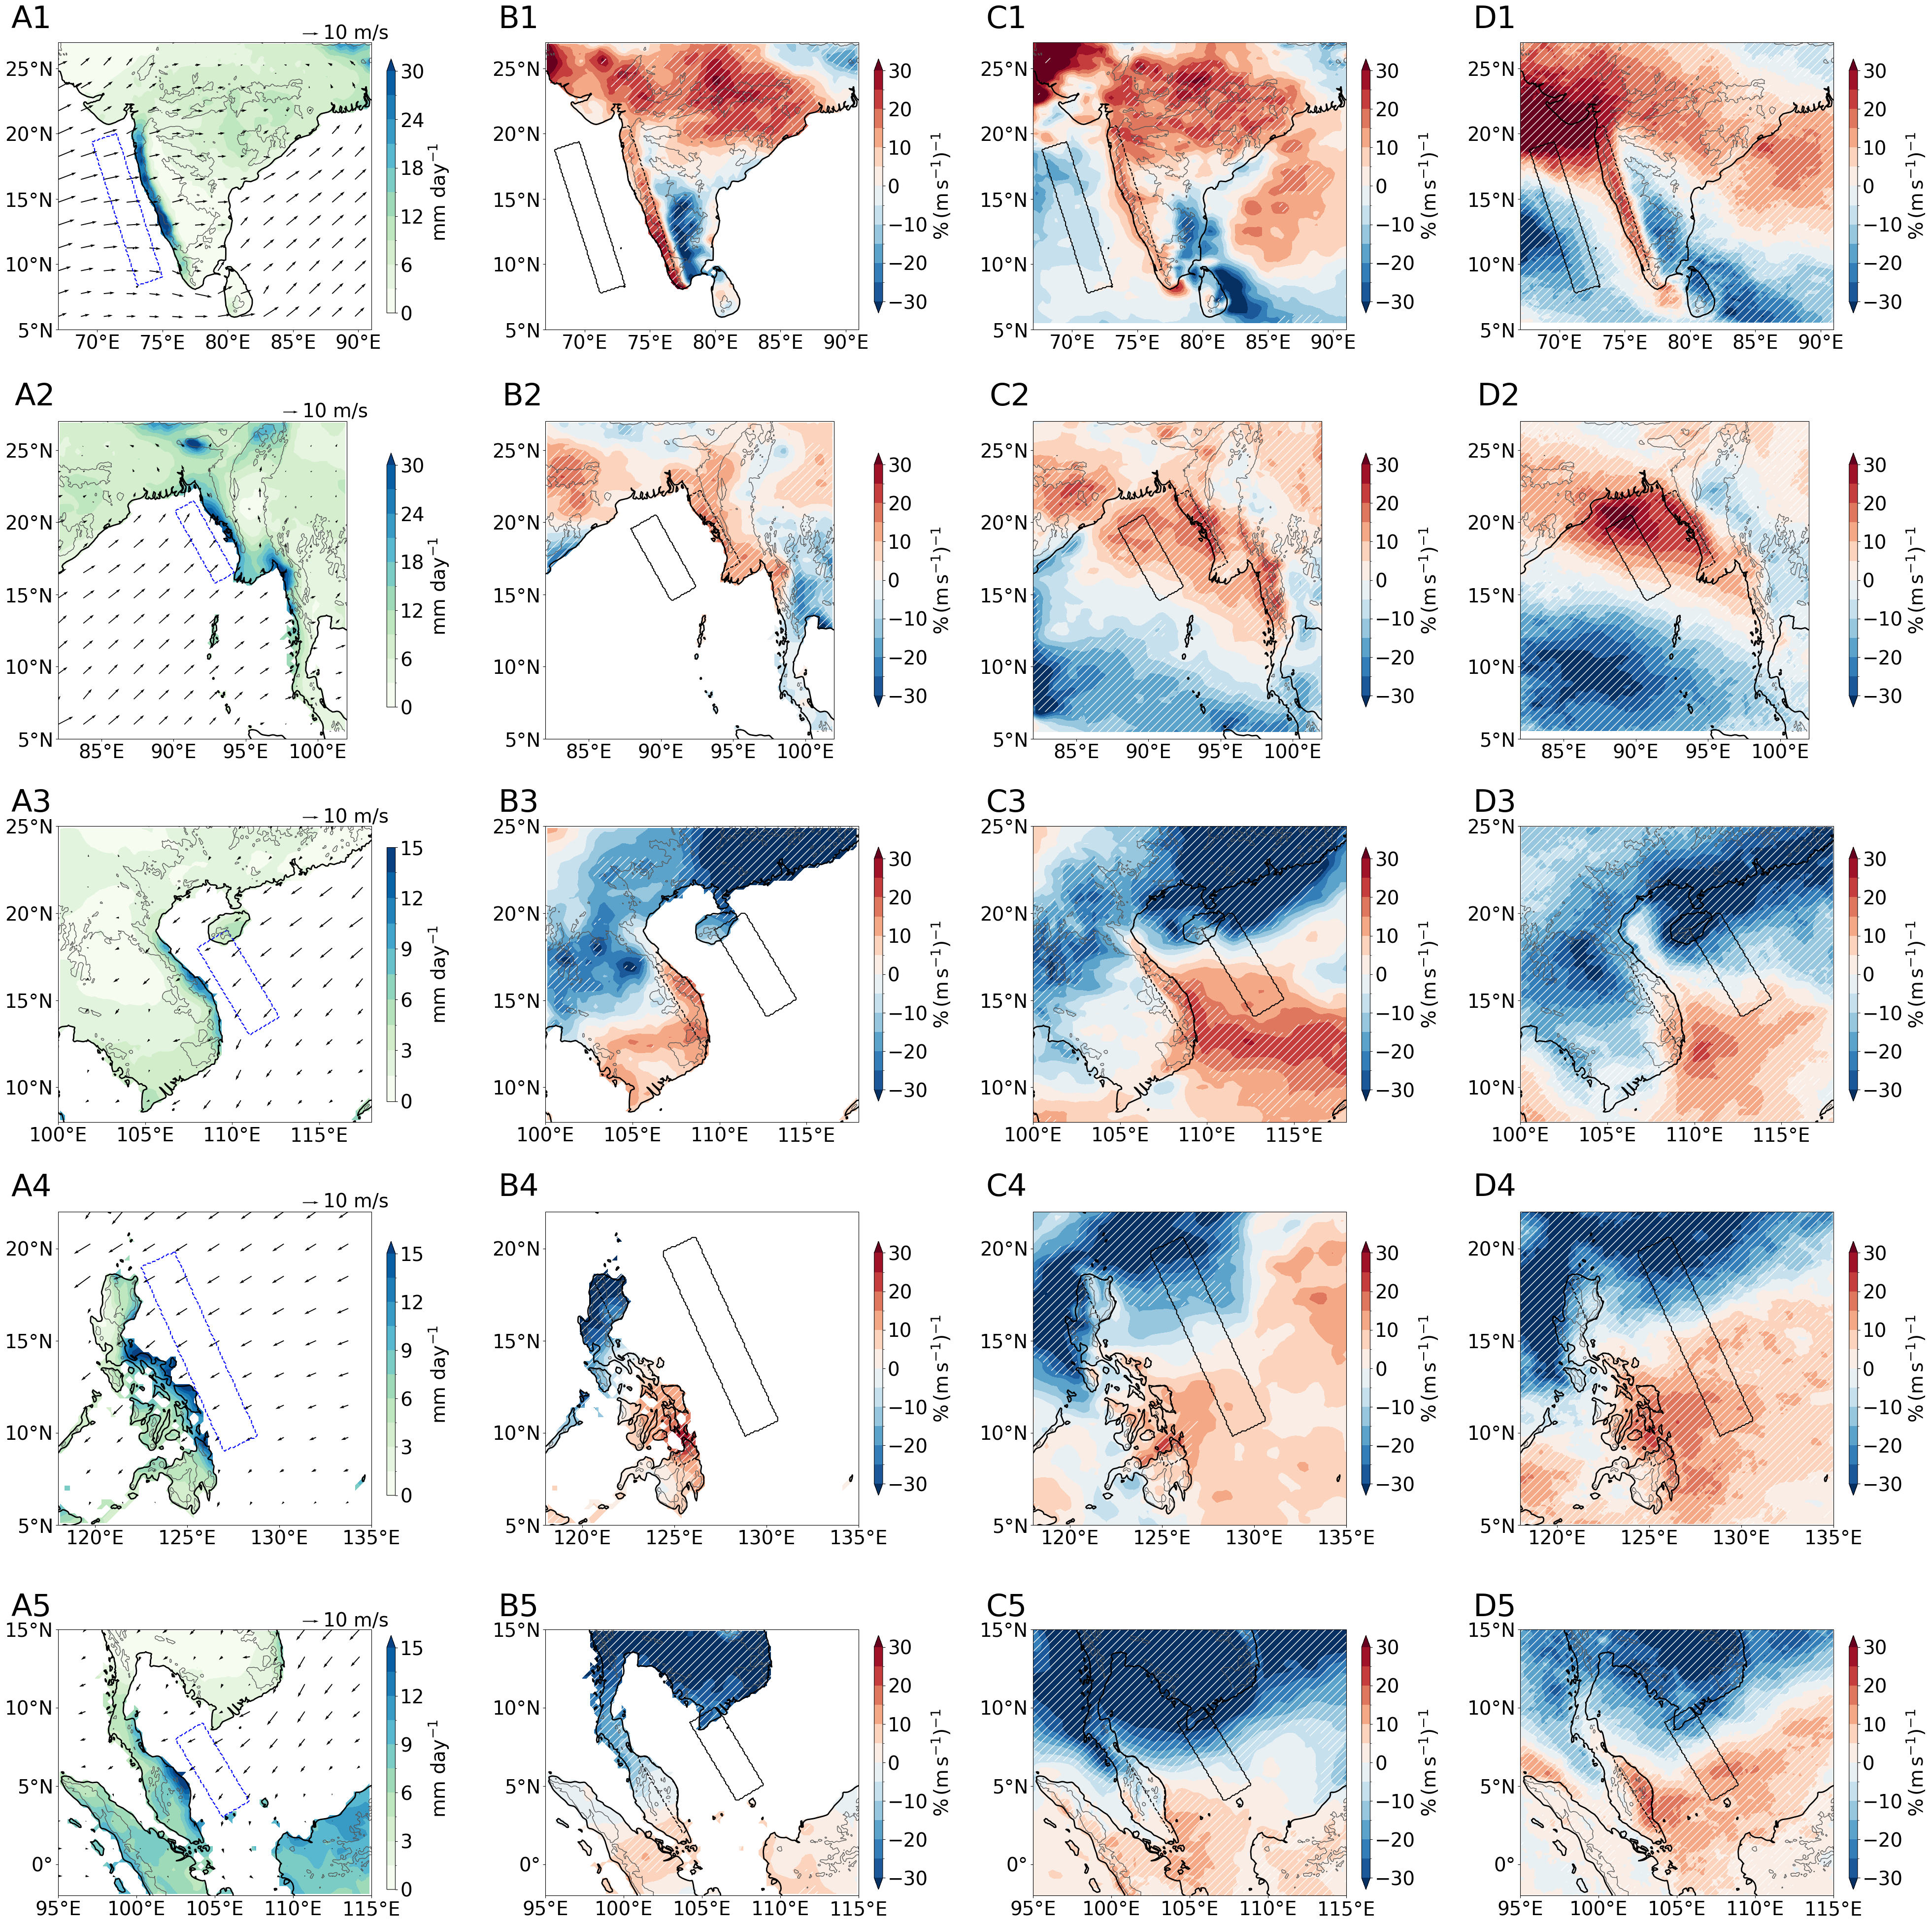

In [82]:
matplotlib.rcParams.update({'font.size':28})
plt.rcParams['hatch.color'] = 'w'

N=5

# Create a figure and a set of subplots
fig,axs = plt.subplots(nrows=N, ncols=4,figsize=(40, 8*N),subplot_kw={'projection':ccrs.PlateCarree()})

# The first row has two panels, each using a cartopy projection PlateCarree
for i,MR in enumerate(MRs[:N]):
    if i<2:
        plot_precip(axs[i,0],MR,APHRODITE,precip_mag=30)
    else:
        plot_precip(axs[i,0],MR,APHRODITE,precip_mag=15)
    plot_reg(axs[i,1],MR,APHRODITE)
    plot_reg(axs[i,2],MR,ERA5)
    plot_reg_daily(axs[i,3],MR)

for ax in axs.reshape(-1):
    ax.set_title('')
for j,letter in enumerate(('A','B','C','D')):
    for i in range(N):
        axs[i,j].text(-0.15,1.05,'%s%i'%(letter,i+1),fontsize=45,transform=axs[i,j].transAxes)
#ax2.text(-0.13,1.01,'B',fontsize=45,transform=ax2.transAxes)
#ax3.text(-0.075,1.,'C',fontsize=45,transform=ax3.transAxes)

fig.tight_layout()
fig.savefig('figs/all_obs_regs.pdf',format='pdf',bbox_inches='tight')

# SI Figure - T & q regressions

In [34]:
%%time
e5_t_1950_1978 = xr.open_zarr("data/globalData/e5.monthly.128_130_t.1950-1978.zarr").t
e5_t_1979_2020 = xr.open_zarr("data/globalData/e5.monthly.128_130_t.1979-2020.zarr").T
e5_q_1950_1978 = xr.open_zarr("data/globalData/e5.monthly.128_133_q.1950-1978.zarr").q
e5_q_1979_2020 = xr.open_zarr("data/globalData/e5.monthly.128_133_q.1979-2020.zarr").Q
e5_t_monthly = xr.concat((e5_t_1950_1978,e5_t_1979_2020),dim='time').sel(time=slice("1960-01-01","2015-12-31"))
e5_q_monthly = xr.concat((e5_q_1950_1978,e5_q_1979_2020),dim='time').sel(time=slice("1960-01-01","2015-12-31"))

e5_t_seasonal_yearly = {}
e5_q_seasonal_yearly = {}
for monthgroup in (6,7,8),(10,11,12),(11,12):
    e5_t_seasonal_yearly[monthgroup] = gt.sel_box_months(e5_t_monthly,box = box, months=monthgroup).groupby('time.year').mean().load()
    e5_q_seasonal_yearly[monthgroup] = gt.sel_box_months(e5_q_monthly,box = box, months=monthgroup).groupby('time.year').mean().load()


CPU times: user 5.29 s, sys: 4.35 s, total: 9.64 s
Wall time: 23 s


In [35]:
def plot_tqregs(MR,dataset,ax=None,close=True):
    ### DATA
    box_region = MR.box
    rect_region = MR.tilted_rect
    angle = MR.angle
    mask_region = gt.sel_box(dataset.region_masks[MR.name],box_region)
    
    u100 = e5_100u_seasonal_yearly[tuple(MR.months)].sel(year=slice(1960,2015))
    v100 = e5_100v_seasonal_yearly[tuple(MR.months)].sel(year=slice(1960,2015))
    t = e5_t_seasonal_yearly[tuple(MR.months)].sel(year=slice(1960,2015))
    q = e5_q_seasonal_yearly[tuple(MR.months)].sel(year=slice(1960,2015))
    
    crossslopeu = gt.crossslopeflow(u100,v100,angle)
    mask_wind = mu.tilted_rect(u100,*rect_region,True)
    
    if close:
        mask_upstream = mask_wind
    else:
        mask_upstream = mu.tilted_rect_distance(t,*rect_region[:-1],-2,-4)
    
        
    wind_ts = gt.spatial_mean(crossslopeu,mask = mask_wind)
    
    if ax is None:
        fig,ax=plt.subplots(1,1,figsize=(5,7))
    
    t_tz = gt.spatial_mean(t,mask = mask_upstream)
    q_tz = 2.5e3*gt.spatial_mean(q,mask = mask_upstream)
    #mask_region_e5 = ERA5.region_masks[MR.name]
    #t_tz_above = gt.spatial_mean(t,mask = mask_region_e5).load()
    #q_tz_above = 2.5e3*gt.spatial_mean(q,mask = mask_region_e5).load()
    
    for ta,qa,c0,c1 in [(t_tz,q_tz,'C1','C0'),]:#(t_tz_above-t_tz,q_tz_above-q_tz,'C2','C3')
        t_reg = gt.linregress_xr(wind_ts,ta,dim='year')
        q_reg = gt.linregress_xr(wind_ts,qa,dim='year')
        ax.plot(t_reg.slope,t.level,label='T',color=c0,linewidth=3)
        ax.plot(q_reg.slope,t.level,label='q',color=c1,linewidth=3)
        ax.fill_betweenx(t.level,t_reg.slope - t_reg.slope_sterr, t_reg.slope + t_reg.slope_sterr, color=c0,alpha=0.2)
        ax.fill_betweenx(t.level,q_reg.slope - q_reg.slope_sterr, q_reg.slope + q_reg.slope_sterr, color=c1,alpha=0.2)
    
    ax.set_ylim(1010,10)
    ax.set_xlim(-1.,1.)
    ax.grid()
    ax.set_title(MR.Lname)

CPU times: user 12 s, sys: 17.4 s, total: 29.4 s
Wall time: 26.4 s


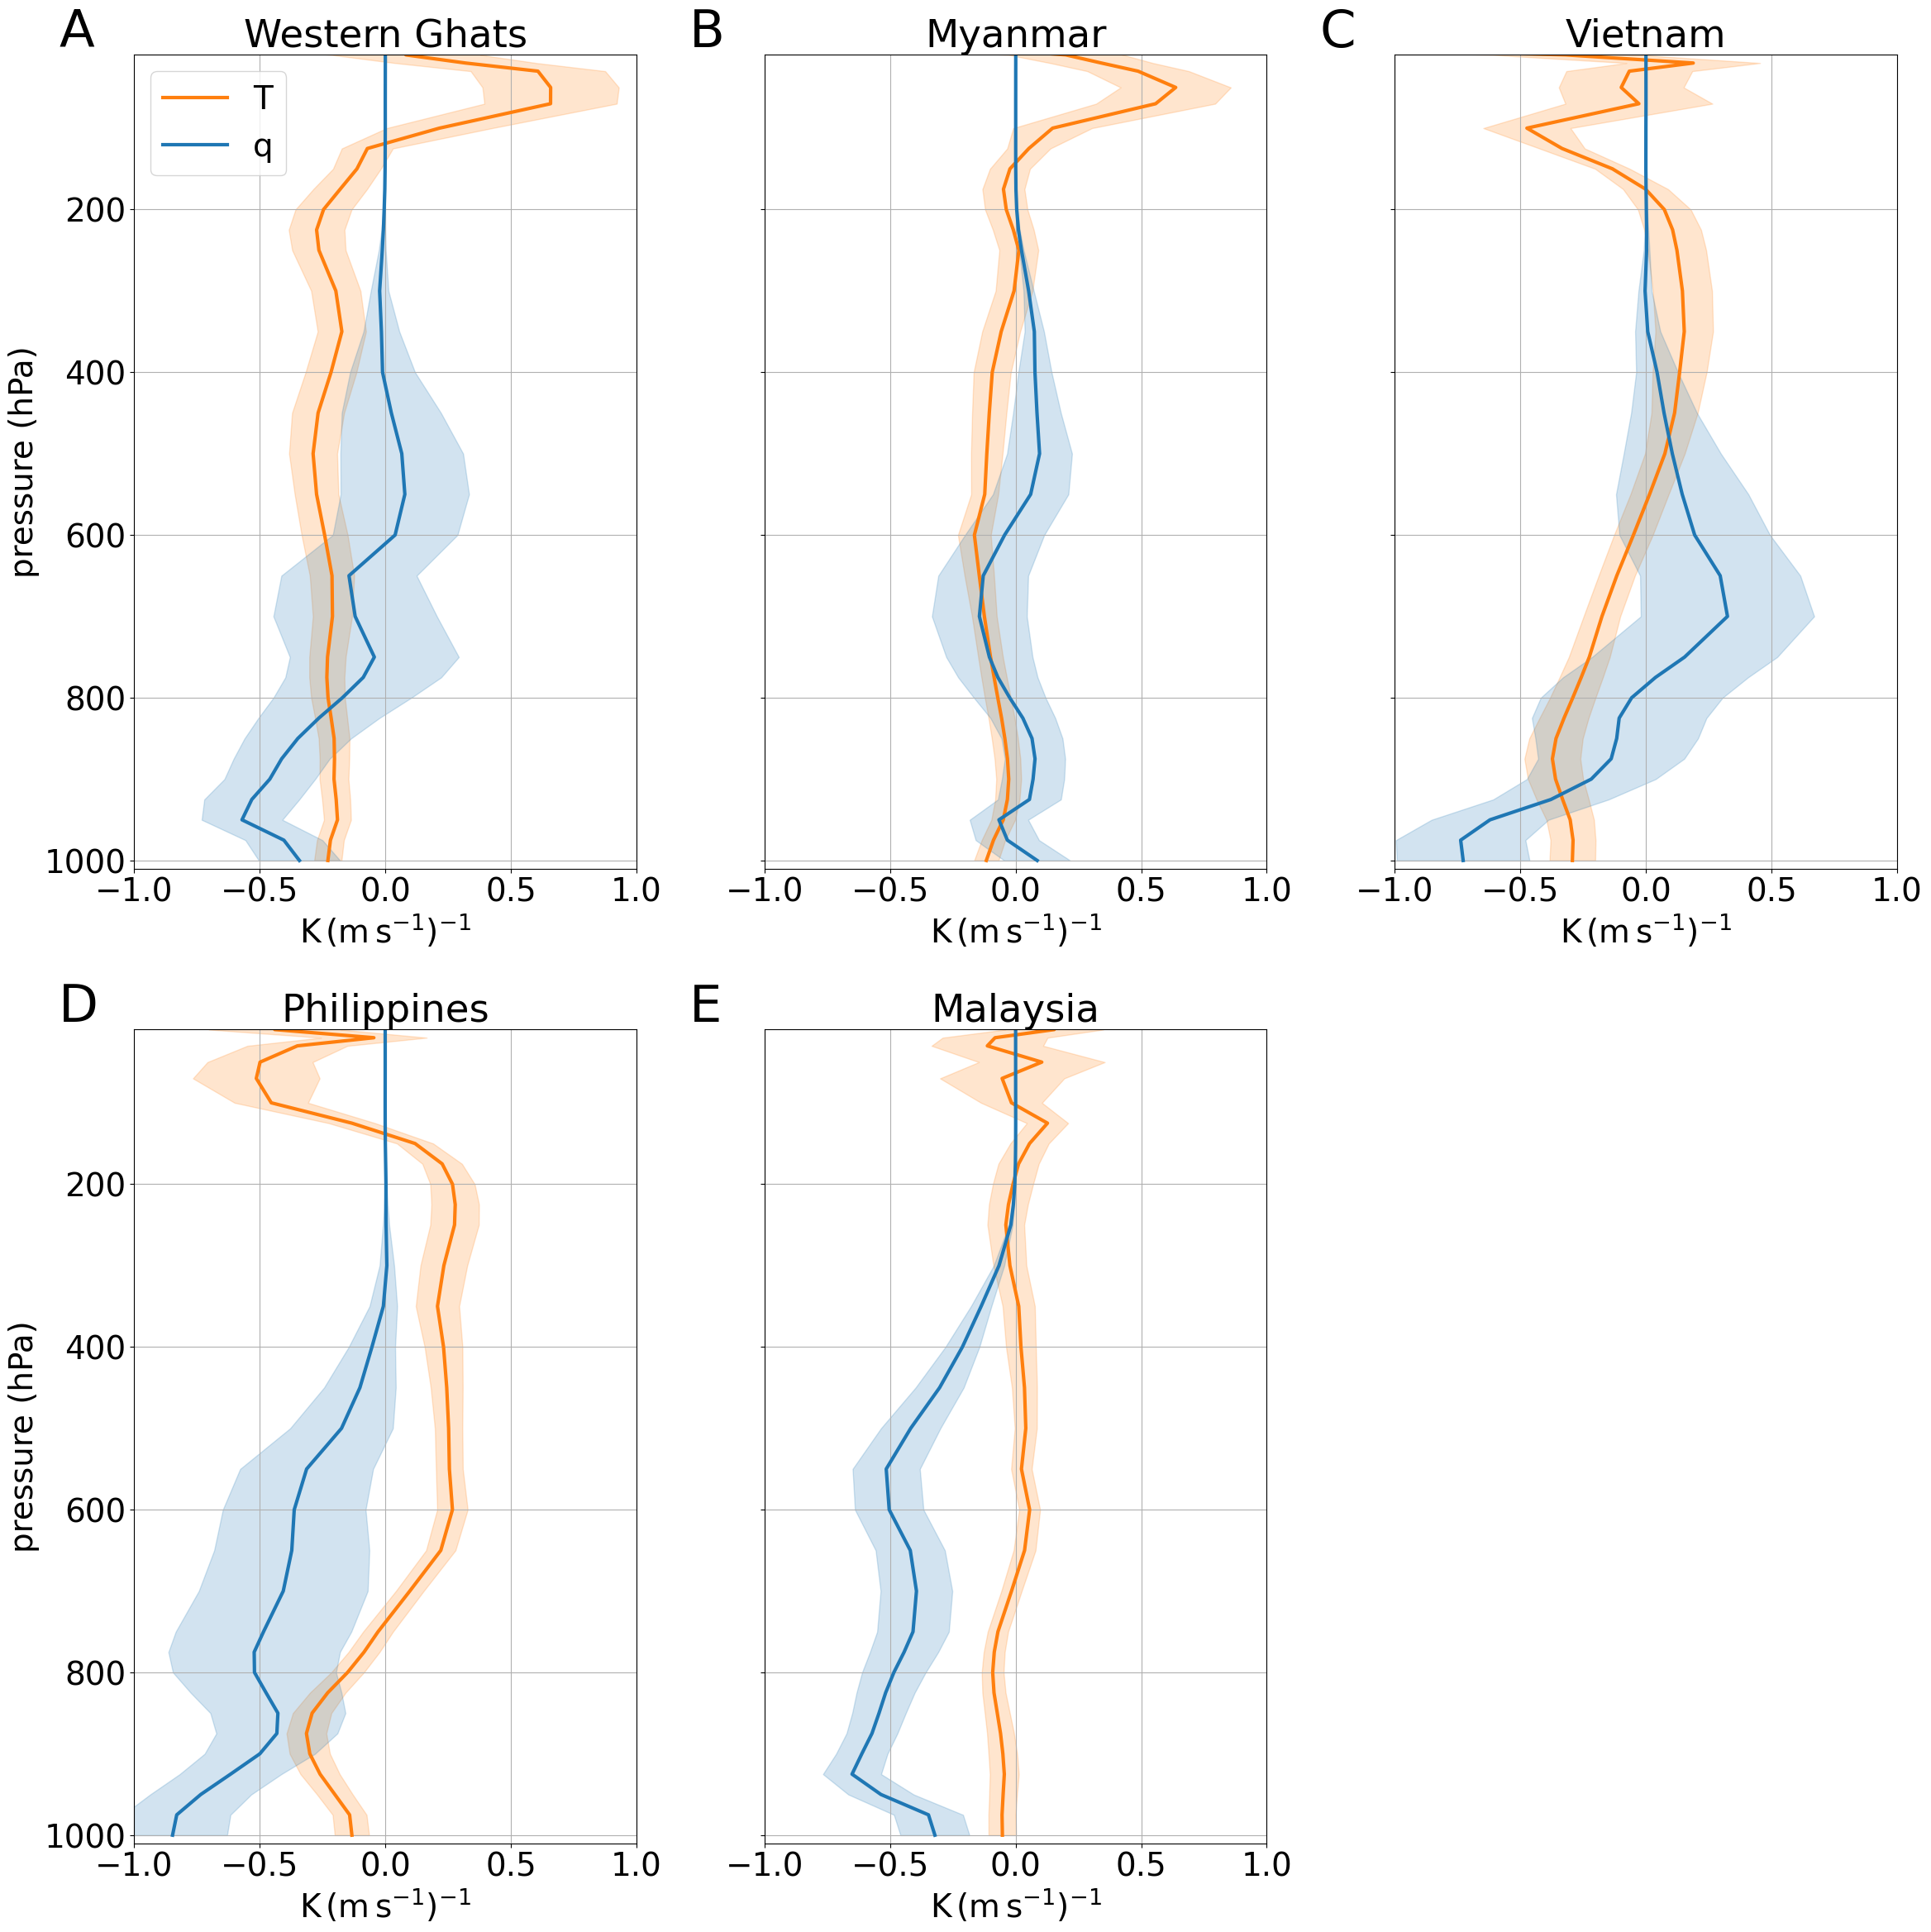

In [83]:
%%time
matplotlib.rcParams.update({'font.size':28})
fig,axs = plt.subplots(2,3,figsize=(24,24)); axs=axs.reshape(-1)
for MR,ax in zip(MRs,axs):
    plot_tqregs(MR,APHRODITE,ax=ax,close=False)
axs[5].remove()

for i,letter in enumerate(('A','B','C','D','E')):
    axs[i].text(-0.15,1.01,'%s'%(letter),fontsize=45,transform=axs[i].transAxes)
    if i%3!=0:
        axs[i].set_ylabel('')
        axs[i].set_yticklabels('')
    else:
        axs[i].set_ylabel('pressure (hPa)')
    axs[i].set_xlabel('K$\,$(m$\,$s$^{-1}$)$^{-1}$')
axs[0].legend()
fig.tight_layout()
fig.savefig('figs/Tqregs.pdf',format='pdf',bbox_inches='tight')

In [ ]:
tar -zcvf globalData.tar.gz globalData/
tar -zcvf regionsData.tar.gz regionsData/
tar -zcvf wrfData.tar.gz wrfData/